# DataKind smallholder farms DataKit study: financial inclusion

This notebook looks at financial inclusion related questions in English in the dataset file, raw_dataset_producers_direct.csv. The file has approximately 2.85M unique English-language questions. These questions were filtered on typical financial-inclusion-related keywords (like 'money,' and 'loan'), to produce a subset of 237K questions. The questions in the subset were then put through a classifier, and classified by one of seven categories, as described below.

Some general insights:
* "profit" and "startup" as question categories: that questions of these types were prevalent enough to warrant categories suggests significant groups of farmers are actively looking for information on how to get started, and how to best sustain profitability--so timely information and instruction in those areas may be important; the "startup" category, also had a strong skew toward livestock-oriented questions (vs crops), which may reflect greater complexity to livestock farming and a greater need for information
* Covid as a natural experiment: the onset of Covid coincided with spikes in questions about loans, and, more moderately, questions about prices and markets; monitoring these question classes, especially loans, might help identify economic distress in farmers
* time series and seasonality: evidence of planting/harvesting cycles, on roughly a quarterly basis, was either minimal, or drowned out by strong monthly oscillations in question frequency across all financial topics; there is somewhat more evidence of planting/harvesting seasonality in Uganda, which, going by question topic counts, was more crop-oriented than Kenya, with Kenya more livestock oriented

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import re
from collections import Counter
import json
import random
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

In [2]:
pathname = '/home/wot/projects/DataKind_farmers/financial_inclusion_data/'
pathshort = '/home/wot/projects/DataKind_farmers/'
conv_file = 'topics_convert.json'  # for plant and animal name categories

In [3]:
FI_filename = 'FI_labeled_merge.csv'

In [4]:
# main financial inclusion dataframe, with approximately 237K rows
df_fi = pd.read_csv(pathname+FI_filename)

In [5]:
# dictionary for "flattening" plant and animal names: maize, potato, tomato, ... -> plant, 
# and similar for animal(s)
plant_animal_flat_conv = {}
if conv_file != '':
    with open(pathshort+conv_file, 'r') as file:
        plant_animal_flat_conv = json.load(file)

In [6]:
'''
org_idx = index in original raw_dataset_producers_direct.csv file
fi_topic = topic category from old topic model (~unreliable)
org_topics = all topics from original file (eg 'maize') associated with that question id
class = class predicted by the text classification process
predicted = True if class was predicted from SVM model; False if
    the result of Claude labeling
'''
class_list = ['pce','mkt','sta','pft','lon','mny','msc']
df_fi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237383 entries, 0 to 237382
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   org_idx                     237383 non-null  int64 
 1   question_content            237383 non-null  object
 2   question_id                 237383 non-null  int64 
 3   clean_text                  237383 non-null  object
 4   fi_topic                    237383 non-null  object
 5   question_user_id            237383 non-null  int64 
 6   question_language           237383 non-null  object
 7   question_sent               237383 non-null  object
 8   question_user_country_code  237383 non-null  object
 9   question_user_gender        10819 non-null   object
 10  question_user_dob           18959 non-null   object
 11  question_user_created_at    237383 non-null  object
 12  org_topics                  237383 non-null  object
 13  class                       2

## Classification categories

Each row in the class column contains one of the following 7 string labels:
* pce--for pricing related questions: "what is the price of medium goat"
* mkt--regarding market availability, and buying and selling items: "I have kienyeji eggs for sale. can i get buyers please"
* sta--for farming business startup-related questions: "how much capital do one need to start up pig farming as business
"
* pft--for questions about future farming prospects and profits: "Which cash crop can i plant  at this season  make a good money"
* lon--for loan- and borrowing-specific questions: "I want to borrow me 500000 shillings to increase my business."
* mny--for more general questions related to obtaining money for farming: "I need money from wefarm so as to improve productivity in my cows?"
* msc--for any questions you can't categorize as above, or are unsure of: "What herbicide should i buy"

### Notes on classification accuracy

There are several potential sources of inaccuracies in the classifications:
* The initial keyword filter that produced 237K rows of candidate questions involving financial inclusion--this filter was not exhaustive, though casual inspection indicated it captured a reasonably high proportion of questions that would be considered related to financial inclusion
* The classification of each of the 237K rows also has potential inaccuracies:
  * The categories were determined from topic models and inspection, and important additional classes may be missing, or the existing classes may be too broad
  * Anthropic's Claude was used to label 4.3K rows for class labels; Claude was not perfect, and may have mislabeled some of the questions
  * An SVM model with rbf was used to train on Claude's labels, then extend the classification to the remaining 233K rows--the SVM model showed a little over 80% accuracy, with the confusion matrix showing the best results for the 'pce', 'mkt', 'sta', 'pft', and 'lon' categories, with greater inaccuracies for the 'mny' and 'msc' categories

In [6]:
pd.set_option('display.max_columns', None)   # to show full dataframe
# when printing--will display all columns
pd.set_option('display.max_colwidth', None)   # to display full column 
# content (for strings)
df_sub = df_fi.sample(5)
df_sub[['question_content','class']]

question_content class
135443      Where can i buy popcon in ibanda district   mkt
17573          how much can jensy cost if iwant 2 buy   mkt
163537             what is the price of 1kg of coffee   pce
35965          Q do wefarm give out loans to farmers?   lon
165775  Q how much do we sell a rabbit's meat per kg?   pce

## Financial inclusion question frequencies

The following plot reveals that questions about markets (buying / selling / access) and price / costs for products dominate the categories. The third-highest category involves questions about prospective profits.

In [8]:
num_ue_questions = 2.85e6    # approximate number of unique English language questions in the dataset

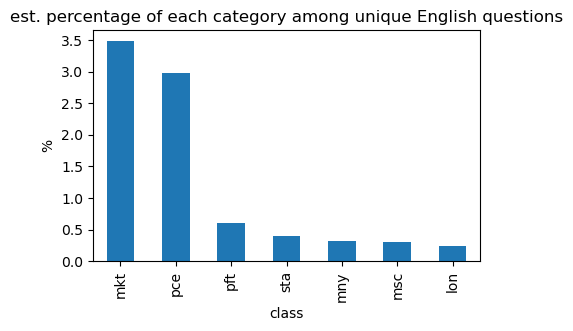

In [9]:
class_fqs = 100*df_fi['class'].value_counts() / num_ue_questions
class_fqs.plot(kind='bar', figsize=(5,3), title='est. percentage of each category among unique English questions', 
              ylabel='%')
plt.show()

This can be further broken down by country. Unfortunately, there is a large sample imbalance by country in the unique English language subset of the overall data. There are only about 150 unique English language questions from users with country code 'gb' (which must be Gabon), and less than 10 English language questions from users with country code 'tz' (Tanzania). For the remainder of this analysis, the countries 'gb' and 'tz' will be removed.

In [10]:
# by country
df_group_cc = df_fi.groupby(['question_user_country_code','class'])
cc_fqs = df_group_cc['org_idx'].count()
cc_fqs

question_user_country_code  class
gb                          lon          6
                            mkt          4
                            pft          1
ke                          lon       5010
                            mkt      62185
                            mny       4640
                            msc       5087
                            pce      26144
                            pft       9107
                            sta       6236
ug                          lon       1693
                            mkt      37036
                            mny       4524
                            msc       3701
                            pce      58824
                            pft       8224
                            sta       4961
Name: org_idx, dtype: int64

In [6]:
df_fi = df_fi.loc[(df_fi['question_user_country_code']=='ke') | (df_fi['question_user_country_code']=='ug')].copy()

In [12]:
df_group_cc = df_fi.groupby('question_user_country_code')

In [13]:
country_dct = {'ug':'Uganda','tz':'Tanzania','ke':'Kenya','gb':'Gabon'}

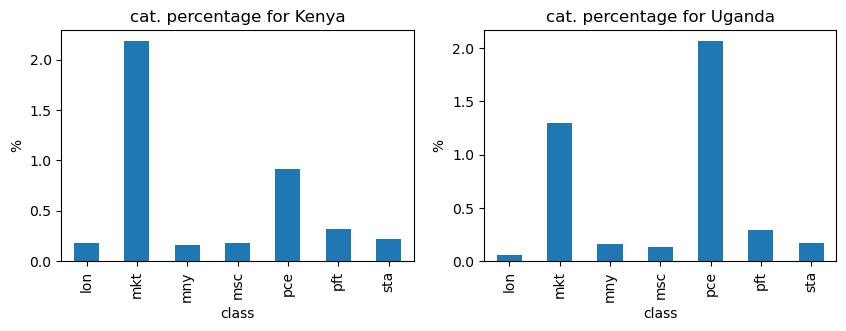

In [14]:
# look at Kenya and Uganda separately; percentages are relative to total unique English questions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axes = axes.flatten() # Flatten for easy iteration
for ii, (name,group) in enumerate(df_group_cc):
    ax = axes[ii]
    df_subgroup = 100*group.groupby('class')['org_idx'].count() / num_ue_questions
    df_subgroup.plot(kind='bar',title='cat. percentage for %s' % country_dct[name], 
              ylabel='%',ax=ax)

## Initial time series analysis

An overview of how the financial inclusion categories change over time will be useful.

In [7]:
# set question sent time as index for easier plotting
df_fi['question_sent'] = pd.to_datetime(df_fi['question_sent'],format='mixed')
df_fi_dt = df_fi.set_index('question_sent')

In [16]:
# obtain frequencies by topic; bin on calendar weeks
class_counts = df_fi_dt.groupby('class').resample('W').size()   # ME=monthly; W=weekly; D=daily

# convert to pivot table
class_counts = class_counts.unstack('class').fillna(0)

In [17]:
class_counts.head(3)

class                      lon  mkt  mny  msc  pce  pft  sta
question_sent                                               
2017-11-26 00:00:00+00:00    4  194    5   13  145   20   12
2017-12-03 00:00:00+00:00    5  426   10   19  202   49   46
2017-12-10 00:00:00+00:00    1  299    5    9  208   30   25

The following stacked area chart of classes as a function of time shows a few things:
* questions about market and price clearly dominate
* there is a high degree of cyclicity (regular spikiness)
* there is an overall surge in activity in the last 6 months of 2018
* at or around September, 2021, there is a big dropoff in activity--the data beyond this point may be of questionnable use for this analysis

In [18]:
# function for creating stacked area charts (details courtesy ChatGPT):

def stacked_area(in_df, title = None):

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.stackplot(
        in_df.index,
        in_df.T.values,
        labels=in_df.columns
    )
    ax.legend(loc='upper left')
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    plt.show()

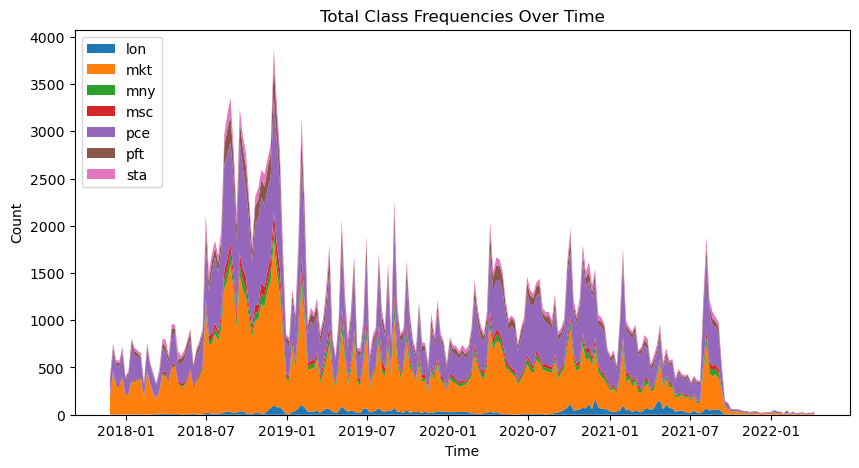

In [19]:
stacked_area(class_counts,title='Total Class Frequencies Over Time')

Zooming in on the end region of the time series suggests a cutoff of around 9/15/2021 for useful data:

In [20]:
date_cutoff = datetime.datetime.strptime("2021-07-01 +0000","%Y-%m-%d %z")

In [21]:
class_sub = class_counts[class_counts.index >= date_cutoff]

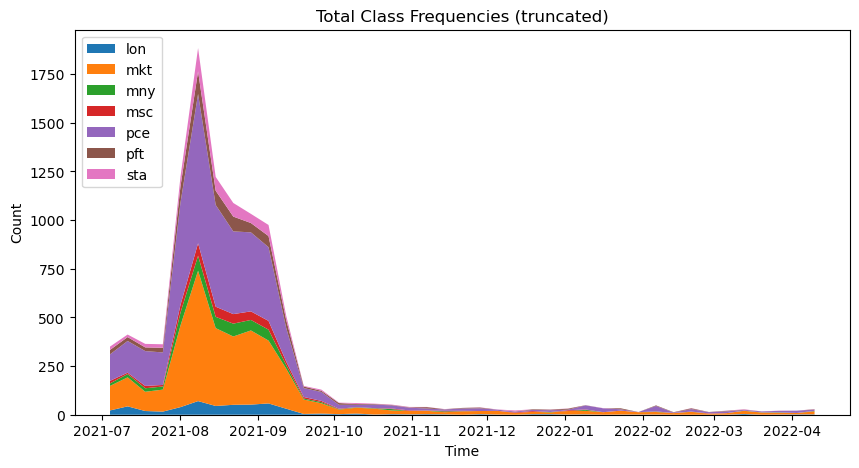

In [22]:
stacked_area(class_sub,title='Total Class Frequencies (truncated)')

In [8]:
# truncate data to <= 9/15/2021
date_trunc = datetime.datetime.strptime("2021-09-15 +0000","%Y-%m-%d %z")
df_fi_dt = df_fi_dt[df_fi_dt.index <= date_trunc]

### Overall English language question and signup activity

The stacked area plots show many prominent fluctuations in the financial inclusion categories for the 3.5 year period of interest in the data. Let's see how this compares with (a) the number of overall English language questions asked (not just those related to financial inclusion), and (b) the number of signups for the WeFarm SMS service. Both of these frequencies were pulled from the raw "raw_dataset_producers_direct.csv" file, and computed daily, in a short, separate script (not shown).

For better viewing, the plot smooths both time series using a 15 day moving average.

In [25]:
# load overall English question frequency data
df_eng_qst_frq = pd.read_csv(pathshort+'eng_lang_daily_frqs.csv')
# load English question-asker user signup frequency data
df_eng_snu_frq = pd.read_csv(pathshort+'eng_lang_signup_times.csv')

In [26]:
df_eng_qst_frq.head(3)

question_user_country_code              question_sent    0
0                         gb  2017-12-12 00:00:00+00:00  1.0
1                         gb  2017-12-13 00:00:00+00:00  0.0
2                         gb  2017-12-14 00:00:00+00:00  0.0

In [27]:
df_eng_snu_frq.head(3)

question_user_country_code   question_user_created_at    0
0                         gb  2015-10-29 00:00:00+00:00  1.0
1                         gb  2015-10-30 00:00:00+00:00  0.0
2                         gb  2015-10-31 00:00:00+00:00  0.0

In [28]:
# fix column name(s), and remove low-frequency countries:
df_eng_qst_frq.rename(columns={'0':'count'},inplace=True)
df_eng_snu_frq.rename(columns={'0':'count'},inplace=True)
df_eng_qst_frq = df_eng_qst_frq.loc[(df_eng_qst_frq['question_user_country_code']=='ug') | 
    (df_eng_qst_frq['question_user_country_code']=='ke')]
df_eng_snu_frq = df_eng_snu_frq.loc[(df_eng_snu_frq['question_user_country_code']=='ug') | 
    (df_eng_snu_frq['question_user_country_code']=='ke')]
df_eng_qst_frq['question_sent'] = pd.to_datetime(df_eng_qst_frq['question_sent'],format='mixed')
df_eng_snu_frq['question_user_created_at'] = pd.to_datetime(df_eng_snu_frq['question_user_created_at'],format='mixed')

In [29]:
# ignore country specificty for now--just want total daily counts
qst_frq = df_eng_qst_frq.groupby('question_sent')['count'].sum()
snu_frq = df_eng_snu_frq.groupby('question_user_created_at')['count'].sum()

In [30]:
qst_frq.head(3)

question_sent
2017-11-22 00:00:00+00:00     458.0
2017-11-23 00:00:00+00:00     843.0
2017-11-24 00:00:00+00:00    1026.0
Name: count, dtype: float64

In [31]:
snu_frq.head(3)

question_user_created_at
2014-11-27 00:00:00+00:00     7.0
2014-11-28 00:00:00+00:00    66.0
2014-11-29 00:00:00+00:00     0.0
Name: count, dtype: float64

In [32]:
# apply some smoothing (simple moving average)
window_size = 15  # smoothing window (in days)
y_qst = pd.Series(qst_frq.values).rolling(window=window_size, center=True).mean()
y_snu = pd.Series(snu_frq.values).rolling(window=window_size, center=True).mean()

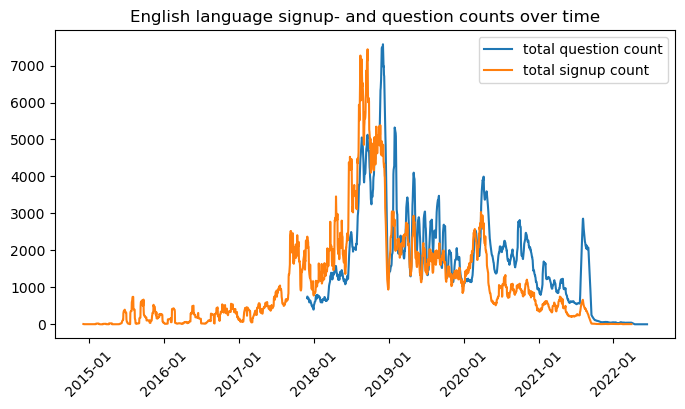

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(qst_frq.index,y_qst,label='total question count')
ax.plot(snu_frq.index,y_snu,label='total signup count')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Optional: format labels

plt.xticks(rotation=45) # Rotate labels for better readability
plt.title("English language signup- and question counts over time")
plt.legend()
plt.show()

Overall, some of the major fluctuations in the financial inclusion data category frequencies, shown in the stacked area charts, appear to be correlated with the overall question activity. For example, the large surge in activity in the last 6 months of 2018 appears in the overall question frequency, and signup frequency as well. The overall question activity in turn seems correlated with sign-up activity in the 2018-2022 time window. Separating out this macroscopic activity effect, in order to better see within-year seasonal variations in financial inclusion topics, is somewhat challenging.

One approach would be to normalize on the total question count. The drawback with this is that seasonal variations may see coincident surges in questions of other types (types beyond just financial inclusion questions), which could unwantedly mask seasonal effects in the financial inclusion categories.

Another approach would be to single out years in which the macroscopic activity effect is minimal. For example, the calendar year 2019 looks relatively stable with respect to overall question activity, and with respect to signup surges. It also stays clear of any effects of Covid, which are a little unclear on the agricultural sector after brief research--see for example a report on Kenya: https://openknowledge.worldbank.org/entities/publication/7092daa8-a05b-5881-b9e0-c25818a12fec.

### Correlation analysis

A look at correlations between financial inclusion time series might be helpful. Taking the total question frequencies, the total signup frequencies, and the country / class counts, a correlation heatmap shows inter-series dependencies.

In [34]:
# create daily counts; produces multiindex pandas series
df_tmp = df_fi_dt.copy()
df_tmp.index.name = 'datetime'
fic_frq = df_tmp.groupby(['class','question_user_country_code']).resample('D').size()
qst_frq = df_eng_qst_frq.rename(columns={'question_sent':'datetime'}).groupby(['datetime',
                                                            'question_user_country_code'])['count'].sum()
snu_frq = df_eng_snu_frq.rename(columns={'question_user_created_at':'datetime'}).groupby(['datetime',
                                                                'question_user_country_code'])['count'].sum()

In [35]:
fic_frq.head(2)

class  question_user_country_code  datetime                 
lon    ke                          2017-11-23 00:00:00+00:00    1
                                   2017-11-24 00:00:00+00:00    2
dtype: int64

In [36]:
qst_frq.head(2)

datetime                   question_user_country_code
2017-11-22 00:00:00+00:00  ke                            182.0
                           ug                            276.0
Name: count, dtype: float64

In [37]:
snu_frq.head(2)

datetime                   question_user_country_code
2014-11-27 00:00:00+00:00  ke                             7.0
2014-11-28 00:00:00+00:00  ke                            66.0
Name: count, dtype: float64

In [38]:
# break out individual series, by subgroupings; each will have 'datetime' index

grouped_fic = {}  # ie a literal dictionary, each element a Pandas series; tuple keys eg ('ke','lon')
for group_name, group_data in fic_frq.groupby(level=['question_user_country_code','class']):
    grouped_fic[group_name] = group_data.reset_index(level=['question_user_country_code','class'],drop=True)
    
grouped_qst = {}   # keys: 'ke', 'ug'
for group_name, group_data in qst_frq.groupby(level='question_user_country_code'):
    grouped_qst[group_name] = group_data.reset_index(level='question_user_country_code', drop=True)

grouped_snu = {}
for group_name, group_data in snu_frq.groupby(level='question_user_country_code'):
    grouped_snu[group_name] = group_data.reset_index(level='question_user_country_code', drop=True)

In [39]:
# merge series on datetime index into single dataframe

for ii, tup_key in enumerate(grouped_fic):
    grouped_fic[tup_key].name = tup_key[0]+'_'+tup_key[1]+'_count'
    if ii==0:
        df_cor = pd.DataFrame(grouped_fic[tup_key])
    else:
        df_cor = pd.merge(df_cor,grouped_fic[tup_key],left_index=True,right_index=True,how='inner')

for key in grouped_qst:
    grouped_qst[key].name = key+'_qst_count'
    df_cor = pd.merge(df_cor,grouped_qst[key],left_index=True,right_index=True,how='inner')

for key in grouped_snu:
    grouped_snu[key].name = key+'_snu_count'
    df_cor = pd.merge(df_cor,grouped_snu[key],left_index=True,right_index=True,how='inner')

In [40]:
# to reduce trivial correlations, subtract the financial inclusion question counts from the total
# question counts
country = ['ke','ug']
for ct in country:
    cols = [ct+'_'+el+'_count' for el in class_list]
    df_cor[ct+'_qst_count'] = df_cor[ct+'_qst_count']-df_cor[cols].sum(axis=1)

In [41]:
df_cor.head(2)

ke_lon_count  ke_mkt_count  ke_mny_count  \
datetime                                                              
2017-11-24 00:00:00+00:00             2            43             1   
2017-11-25 00:00:00+00:00             0            35             3   

                           ke_msc_count  ke_pce_count  ke_pft_count  \
datetime                                                              
2017-11-24 00:00:00+00:00             2            20             7   
2017-11-25 00:00:00+00:00             3             3             1   

                           ke_sta_count  ug_lon_count  ug_mkt_count  \
datetime                                                              
2017-11-24 00:00:00+00:00             2             0            16   
2017-11-25 00:00:00+00:00             0             0             3   

                           ug_mny_count  ug_msc_count  ug_pce_count  \
datetime                                                              
2017-11-24 00:00:00+00:00             0             0            26   
2017-11-25 00:00:00+00:00             0             0            17   

                           ug_pft_count  ug_sta_count  ke_qst_count  \
datetime                                                              
2017-11-24 00:00:00+00:00             1             0         653.0   
2017-11-25 00:00:00+00:00             1             2         357.0   

                           ug_qst_count  ke_snu_count  ug_snu_count  
datetime                                                             
2017-11-24 00:00:00+00:00         253.0         858.0         724.0  
2017-11-25 00:00:00+00:00         215.0         238.0         485.0

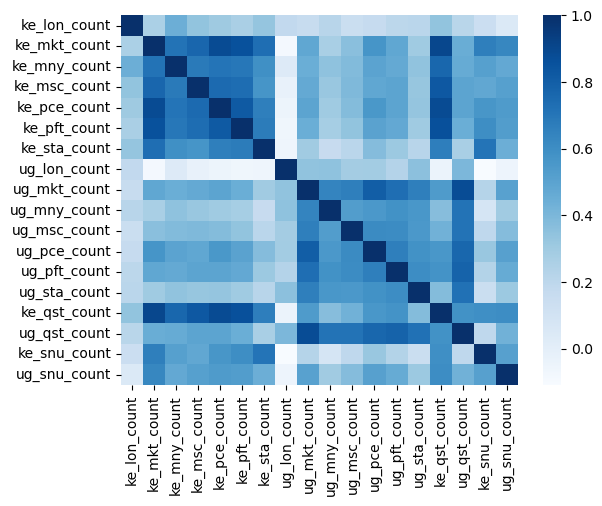

In [42]:
corr_ts = df_cor.corr()
sns.heatmap(corr_ts,cmap="Blues")
plt.show()

The heatmap shows several dependencies, or their lack:

* both the Kenyan and Ugandan overall question counts are fairly highly correlated (~0.6-0.8) with each of the financial inclusion category question counts; the least correlated, for both countries, are questions about loans
* both countries, Kenya and Uganda, show moderate correlations between the financial inclusion category question counts, with Kenya having slightly higher correlations between financial inclusion category counts overall
* between countries, the correlation between financial inclusion category counts appear to be fairly low; the Ugandan loan category stands out as having very near 0 correlation with any of the Kenyan financial inclusion categories, though note the loan category does not have many samples

WeFarm platform signup counts show moderate or lower correlation with all categories. It's reasonable to expect there is a lag between the time of signup, and when the user begins posting at normal levels. However the correlation analysis, just below, by advancing the signup columns' datetime indices by periods of 10, 20, and 30 days, and repeating the correlation calculations between categories, did not increase the average correlations. The maximal correlation appeared at very low or zero time lag.

In [43]:
time_boost = 10 	# in days; tried for 10, 20, 30

In [44]:
# give the snu columns a time boost, then remerge on datetime index back into main cor dataframe
df_tmp = df_cor[['ke_snu_count','ug_snu_count']]
df_tmp.set_index(df_tmp.index+datetime.timedelta(days=time_boost),inplace=True)
df_cor_lag = pd.merge(df_cor.drop(columns=['ke_snu_count','ug_snu_count']),
                      df_tmp,left_index=True,right_index=True,how='inner')

In [45]:
corr_ts_lag = df_cor_lag.corr()
#sns.heatmap(corr_ts_19,cmap="Blues")
#plt.show()

In [46]:
# average |correlation| over all columns, with signup time offset time_boost
np.abs(corr_ts_lag[['ke_snu_count','ug_snu_count']]).mean()

ke_snu_count    0.216942
ug_snu_count    0.335138
dtype: float64

In [47]:
# average |correlation| over all columns, without signup time offset
np.abs(corr_ts[['ke_snu_count','ug_snu_count']]).mean()

ke_snu_count    0.404545
ug_snu_count    0.457555
dtype: float64

The moderate to strong correlations between overall question activity and financial inclusion question activity make it somewhat difficult to meaningfully separate variations between the groups. For example, consider two possibilities:
* something is causing varying participation on the WeFarm platform, such as advertising, general encouragement on its use, or perhaps holiday periods, and all question-type categories vary in rough proportion
* different factors are causing variations in each question topic, with perhaps also general causes that affect both non-FI and FI questions simultaneously

For future analysis, some consideration of cause and effect might be helpful.

The next correlation plot shows the effect of filtering on just the year 2019. This does show slightly lower correlations bewteen the overall question counts and the financial inclusion topics, but correlations remain moderate.

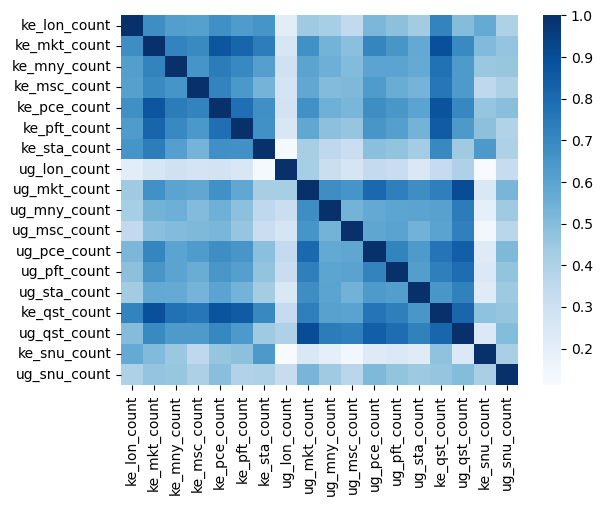

In [48]:
dt_lo = datetime.datetime.strptime("2019-01-01 +0000","%Y-%m-%d %z")
dt_hi = datetime.datetime.strptime("2020-01-01 +0000","%Y-%m-%d %z")
df_cor_19 = df_cor.loc[(df_cor.index>=dt_lo) & (df_cor.index<dt_hi)]
corr_ts_19 = df_cor_19.corr()
sns.heatmap(corr_ts_19,cmap="Blues")
plt.show()

With these considerations in mind, individual time series for country / class pairings will be examined.

## Initial time series

This section will, in part, examine the time series for any seasonal or other intra-year variations.

In [49]:
# for marking typical planting / harvesting seasons; tuples are month (Pythonic) ranges;
# for example (3,6) denotes months March, April, May
season_dct = {'ke': {'planting_1':(3,6), 'planting_2':(10,13)}, 'ug': {'planting_1':(3,6), 'planting_2':(9,12)}}

### Overall trends

First, a look at the country / class trends by year for the financial inclusion-related questions.

In [50]:
# convert to frequency / count table (retaining long format, for Seaborn)
df_plot = df_fi_dt.groupby(['question_user_country_code','class']).resample('W').size()   # ME=monthly; W=weekly; D=daily
df_plot = df_plot.reset_index()
df_plot['year'] = df_plot['question_sent'].dt.year
df_plot['week'] = df_plot['question_sent'].dt.strftime("%U").astype(int)  # helps avoid 1st few days in Jan as week 53
#df_plot['week'] = df_plot['question_sent'].dt.isocalendar().week.astype(int) # for superimposing years on single plot--
# uses iso weeks, and can put 1/3/21 as "week 53"

In [51]:
df_plot.rename(columns={0: 'count','question_user_country_code': 'country'}, inplace=True)

In [52]:
df_plot.head(3)

country class             question_sent  count  year  week
0      ke   lon 2017-11-26 00:00:00+00:00      3  2017    48
1      ke   lon 2017-12-03 00:00:00+00:00      3  2017    49
2      ke   lon 2017-12-10 00:00:00+00:00      1  2017    50

In [53]:
df_plot = df_plot.sort_values(["year", "week"])

In [54]:
# for bands in plot--assumes calendar year interval for the data
cb_dct = {}
year = 2018  # any year will do--will extract week #

for country in ['ke','ug']:
    band_dct = {}
    seasons_months = season_dct[country]
    # assumes these are planting seasons, (month start, month end+1)
    for key in seasons_months:
        tup = seasons_months[key]
        dt_tup = [datetime.datetime.strptime(str(year)+f"{-mon:02}"+"-01 +0000","%Y-%m-%d %z") 
                     if mon <= 12 else datetime.datetime.strptime(str(year)+"-12-24 +0000","%Y-%m-%d %z") for mon in tup]
        band_dct[key] = [date.isocalendar().week 
                         for date in dt_tup]
    cb_dct[country] = band_dct

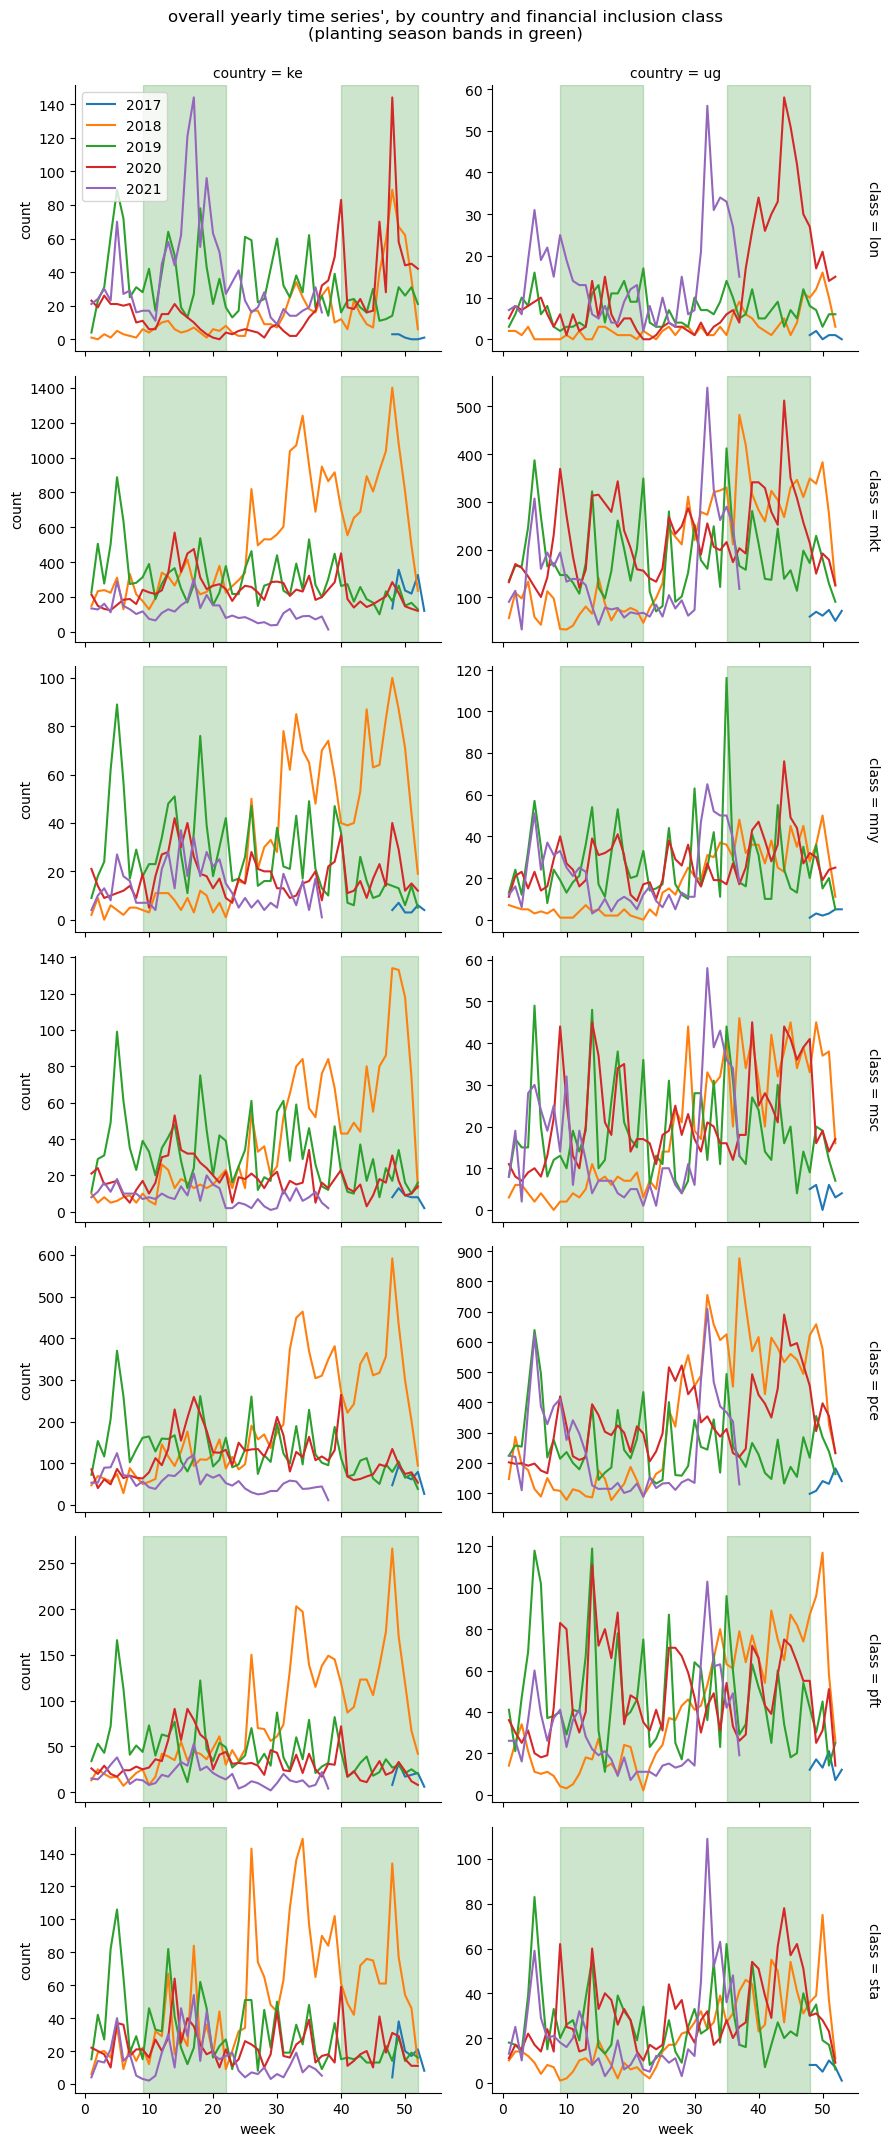

In [55]:
gg = sns.FacetGrid(df_plot, row="class", col="country", hue="year", sharey=False, margin_titles=True,
                  aspect=1.5)
gg.map(sns.lineplot, 'week', 'count')

# Get row and column names
row_names = gg.row_names
col_names = gg.col_names

# Iterate through axes and associate with facet variables
for i, row_val in enumerate(row_names):
    for j, col_val in enumerate(col_names):
        ax = gg.axes[i, j]
        #ax = None
        #print(f"Plot at row '{row_val}', column '{col_val}' (Axes object: {ax})")
        band_dct = cb_dct[col_val]
        for key in band_dct:
        	ax.axvspan(band_dct[key][0], band_dct[key][1], color='green', alpha=0.2)

handles, labels = gg.axes[0, 0].get_legend_handles_labels()
gg.axes[0, 0].legend(handles=handles, labels=labels, loc="upper left")
gg.fig.suptitle("overall yearly time series', by country and financial inclusion class\n(planting season bands in green)", y=1.02) # Adjust 'y' for vertical positioning
plt.show()


In general

* all plots show strong, roughly monthly oscillations
* the second half of 2018 shows a large surge in activity; the fact this occurs across all financial inclusion classes suggests it's an external effect driving questions in general, reflected in the plots above of overall question activity, and overall signup activity
* Covid:
    * some of the financial inclusion class plots, especially the loans class, suggest the negative economic effects of Covid, which began to affect the global economy in mid 2020, and lasted several years
	* for loans, there are notable spikes in loan-related questions for both countries, in late 2020, and early- and late 2021; loan inquiries might generally be reflective of farmers in economic distress
	* for markets and price, there are some indications of spikes in market- and price- oriented questions in Uganda, in late 2020 and late 2021
* seasonality:
    * there is some evidence that Uganda displays some planting/harvesting cycle dependence in 2021--all financial inclusion classes show peaking in the harvest periods, and are relatively flat during the first planting season (Mar-May); this is supported by Uganda potentially being more crop-oriented, and therefore more planting/harvesting oriented, than Kenya (see next sections)
	* in general, it is quite difficult to infer any strong crop-cycle seasonality off these general plots; the monthly oscillations, and the late-year surge in the case of 2018, dominate the plots

To help understand the large oscillations in the data, it may be useful to consider a single year that might be "typical," and perform a basic time series decomposition on it. Since the second half of 2018 seems to have an anomaly in terms of overall question count and signups, and since 2020 and 2021 may suffer from the effects of Covid, the year 2019 will be considered "typical." The most frequent classes are 'mkt' and 'pce'. Kenya, 'mkt' and Uganda, 'pce' have their decompositions plotted. The seasonal period for these is the default 7 (days) for statsmodels tsa seasonal_decompose. These were also tried with a period of 30 days, and essentially gave the same results (a strong monthly cycle, this time in the "Seasonal" category, with "Trend" mostly flat).

In [56]:
dt_lo = datetime.datetime.strptime("2019-01-01 +0000","%Y-%m-%d %z")
dt_hi = datetime.datetime.strptime("2020-01-01 +0000","%Y-%m-%d %z")

df_plot_2 = df_fi_dt.groupby(['question_user_country_code','class']).resample('D').size().reset_index()   # ME=monthly; W=weekly; D=daily
df_plot_2.rename(columns={0:'count','question_user_country_code':'country'},inplace=True)
df_tmp = df_plot_2.loc[(df_plot_2['question_sent']>=dt_lo) & (df_plot_2['question_sent']<dt_hi)]


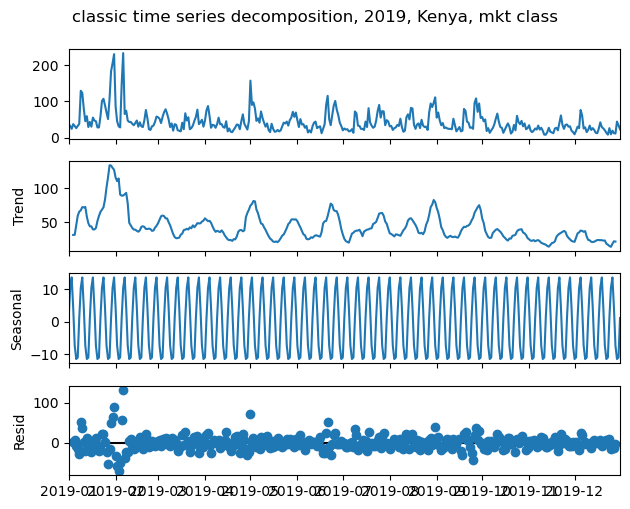

In [57]:
ctry = 'ke'
clas = 'mkt'
res = sm.tsa.seasonal_decompose(df_tmp.loc[(df_tmp['country']==ctry)&(df_tmp['class']==clas)]
                                [['question_sent','count']].set_index('question_sent'))
resplot = res.plot()
resplot.suptitle("classic time series decomposition, 2019, Kenya, mkt class",y=1.05)
plt.show()

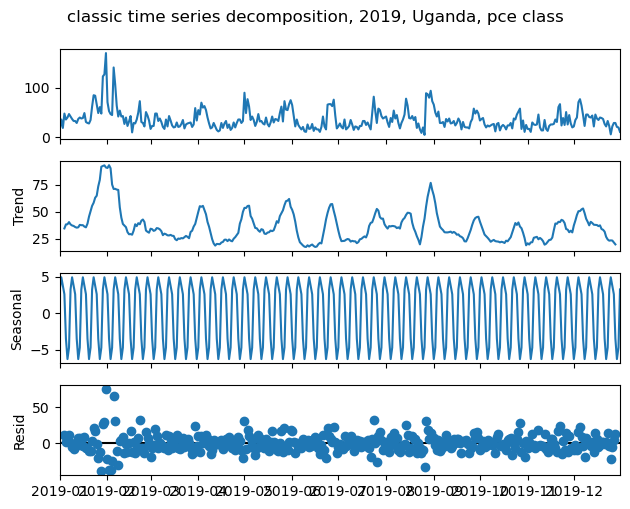

In [58]:
ctry = 'ug'
clas = 'pce'
res = sm.tsa.seasonal_decompose(df_tmp.loc[(df_tmp['country']==ctry)&(df_tmp['class']==clas)]
                                [['question_sent','count']].set_index('question_sent'))
resplot = res.plot()
#plt.title("classic time series decomposition, 2019, Uganda, pce class")
resplot.suptitle("classic time series decomposition, 2019, Uganda, pce class",y=1.05)
plt.show()

Overall, there are strong weekly ("Seasonal") and, approximately, monthly ("Trend") cycles. The monthly cycles tend to peak around the start of each month. These oscillations may obscure any obvious, inter-month seasonal trends.

### Plant / animal subgroupings

Next, the original topic labels from the raw dataset are used to split out more categories for financial inclusion related questions. Questions with topic labels that are all plants will receive the label 'plant.' Questions with topic labels that are all animals will receive the label 'animal.' All other questions, for example those with nan as the topic, or those with mixed topic classes, will be labeled 'other.'

In [105]:
year_int = 2019  # choose a specific year
rol_avg = 15   # number of days to take (centered) rolling averages over

In [106]:
# filter on year, and convert to frequency / count table (retaining long format, for Seaborn)
dt_start = datetime.datetime.strptime(str(year_int)+"-01-01 +0000","%Y-%m-%d %z")
dt_end = datetime.datetime.strptime(str(year_int+1)+"-01-01 +0000","%Y-%m-%d %z")
df_fi_1 = df_fi_dt.loc[(df_fi_dt.index>=dt_start) & (df_fi_dt.index<dt_end)].copy()

In [107]:
# The imported financial inclusion dataframe, df_fi, has an 'org_topics' column, 
# which contains the original topic labeling for each question from the raw dataset:
df_fi_1['org_topics'].head(5)

question_sent
2019-01-01 05:46:36.934205+00:00             {nan}
2019-01-01 06:13:25.926955+00:00          {'bean'}
2019-01-01 06:15:35.979072+00:00    {'strawberry'}
2019-01-01 06:22:03.976082+00:00        {'cattle'}
2019-01-01 06:34:19.766349+00:00        {'rabbit'}
Name: org_topics, dtype: object

In [108]:
# convert {...} strings into lists of topics for each row
def clean_topics(text):
    lst = re.sub(r"[{}']","",text).split(',')
    return [el.strip() for el in lst]

In [109]:
df_fi_1['clean_topics'] = df_fi_1['org_topics'].apply(clean_topics)

In [110]:
# test for how many topics are pure 'nan'
df_fi_1['nan_test'] = df_fi_1['clean_topics'].apply(lambda x: x[0]=='nan')# only about 24% of topics are ['nan']:
num_nan = sum(df_fi_1['nan_test'])
print("%s rows with no topic labels, out of %s total" % (num_nan,len(df_fi_1)))

14641 rows with no topic labels, out of 60346 total


In [111]:
# flatten conversions--flatten plurals (plants->plant etc)
plant_animal_flat_conv = {key:value if value != 'plants' else
                          'plant' for key,value in
                          plant_animal_flat_conv.items()}
plant_animal_flat_conv = {key:value if value != 'animals' else
                          'animal' for key,value in
                          plant_animal_flat_conv.items()}
# so at this point, it should be keyed as eg, 'maize':'plant', 'tomatoes':'plant', etc.

In [112]:
# apply category dictionary to topic list column
df_fi_pa = df_fi_1.copy()
df_fi_pa['pa_conv'] = df_fi_1['clean_topics'].apply(lambda lst: ['other' if el not in 
                plant_animal_flat_conv else plant_animal_flat_conv[el] for el in lst])

In [113]:
def pa_complete(lst):
    sbl = [1 if el=='plant' else (-1 if el=='animal' else 0) for el in lst]
    return 'plant' if sum(sbl)==len(sbl) else ('animal' if -sum(sbl)==len(sbl) else 'other')

In [114]:
# re-categorize each converted plant/animal topic list based on purity of plant/animal elements
df_fi_pa['pa_group'] = df_fi_pa['pa_conv'].apply(pa_complete)

In [115]:
# remove rows with 'other' in the pa_group column
df_fi_pa = df_fi_pa.loc[df_fi_pa['pa_group']!='other'].copy()

In [116]:
print("%s rows remaining with pure plant or animal topic labels, out of %s" % (len(df_fi_pa),len(df_fi_1)))

42973 rows remaining with pure plant or animal topic labels, out of 60346


In [117]:
df_fi_pa[['org_topics','clean_topics','pa_group']].head(4)

org_topics  clean_topics pa_group
question_sent                                                          
2019-01-01 06:13:25.926955+00:00        {'bean'}        [bean]    plant
2019-01-01 06:15:35.979072+00:00  {'strawberry'}  [strawberry]    plant
2019-01-01 06:22:03.976082+00:00      {'cattle'}      [cattle]   animal
2019-01-01 06:34:19.766349+00:00      {'rabbit'}      [rabbit]   animal

In [118]:
# group over country / class / plant/animal, and consolidate counts by day;
# resample('D') should produce a contiguous set of days over the spanning range, with
# NA if there are any days missing
df_pa_1 = df_fi_pa.groupby(['class','question_user_country_code','pa_group']).resample('D').size()

In [74]:
df_pa_1[:3]  # (series)

class  question_user_country_code  pa_group  question_sent            
lon    ke                          animal    2020-01-02 00:00:00+00:00    1
                                             2020-01-03 00:00:00+00:00    0
                                             2020-01-04 00:00:00+00:00    1
dtype: int64

In [119]:
# check for nans in contiguous days; resample('D') is guaranteed to create contiguous
# run of consecutive days, covering orginal range
df_pa_1.isna().sum()

np.int64(0)

In [120]:
df_pa_2 = df_pa_1.reset_index(level=['question_user_country_code','class','pa_group']).rename(columns={0:'count'})

In [121]:
df_pa_2 = (df_pa_2.sort_index().groupby(['question_user_country_code','class','pa_group'])['count']
           .rolling(str(rol_avg)+'D',min_periods=1,center=True)
           .mean()
          )

In [122]:
df_plot_pa = df_pa_2.reset_index()
df_plot_pa.rename(columns={0: 'count','question_user_country_code': 'country'}, inplace=True)

In [123]:
df_plot_pa[:5]

country class pa_group             question_sent     count
0      ke   lon   animal 2019-01-07 00:00:00+00:00  0.750000
1      ke   lon   animal 2019-01-08 00:00:00+00:00  0.666667
2      ke   lon   animal 2019-01-09 00:00:00+00:00  0.600000
3      ke   lon   animal 2019-01-10 00:00:00+00:00  0.727273
4      ke   lon   animal 2019-01-11 00:00:00+00:00  0.750000

In [124]:
pa_dct = {}

for country in ['ke','ug']:
    band_dct = {}
    seasons_months = season_dct[country]
    # assumes these are planting seasons, (month start, month end+1)
    for key in seasons_months:
        tup = seasons_months[key]
        dt_tup = [datetime.datetime.strptime(str(year_int)+f"{-mon:02}"+"-01 +0000","%Y-%m-%d %z") 
                     if mon <= 12 else datetime.datetime.strptime(str(year_int)+"-12-31 +0000","%Y-%m-%d %z") for mon in tup]
        band_dct[key] = dt_tup
    pa_dct[country] = band_dct

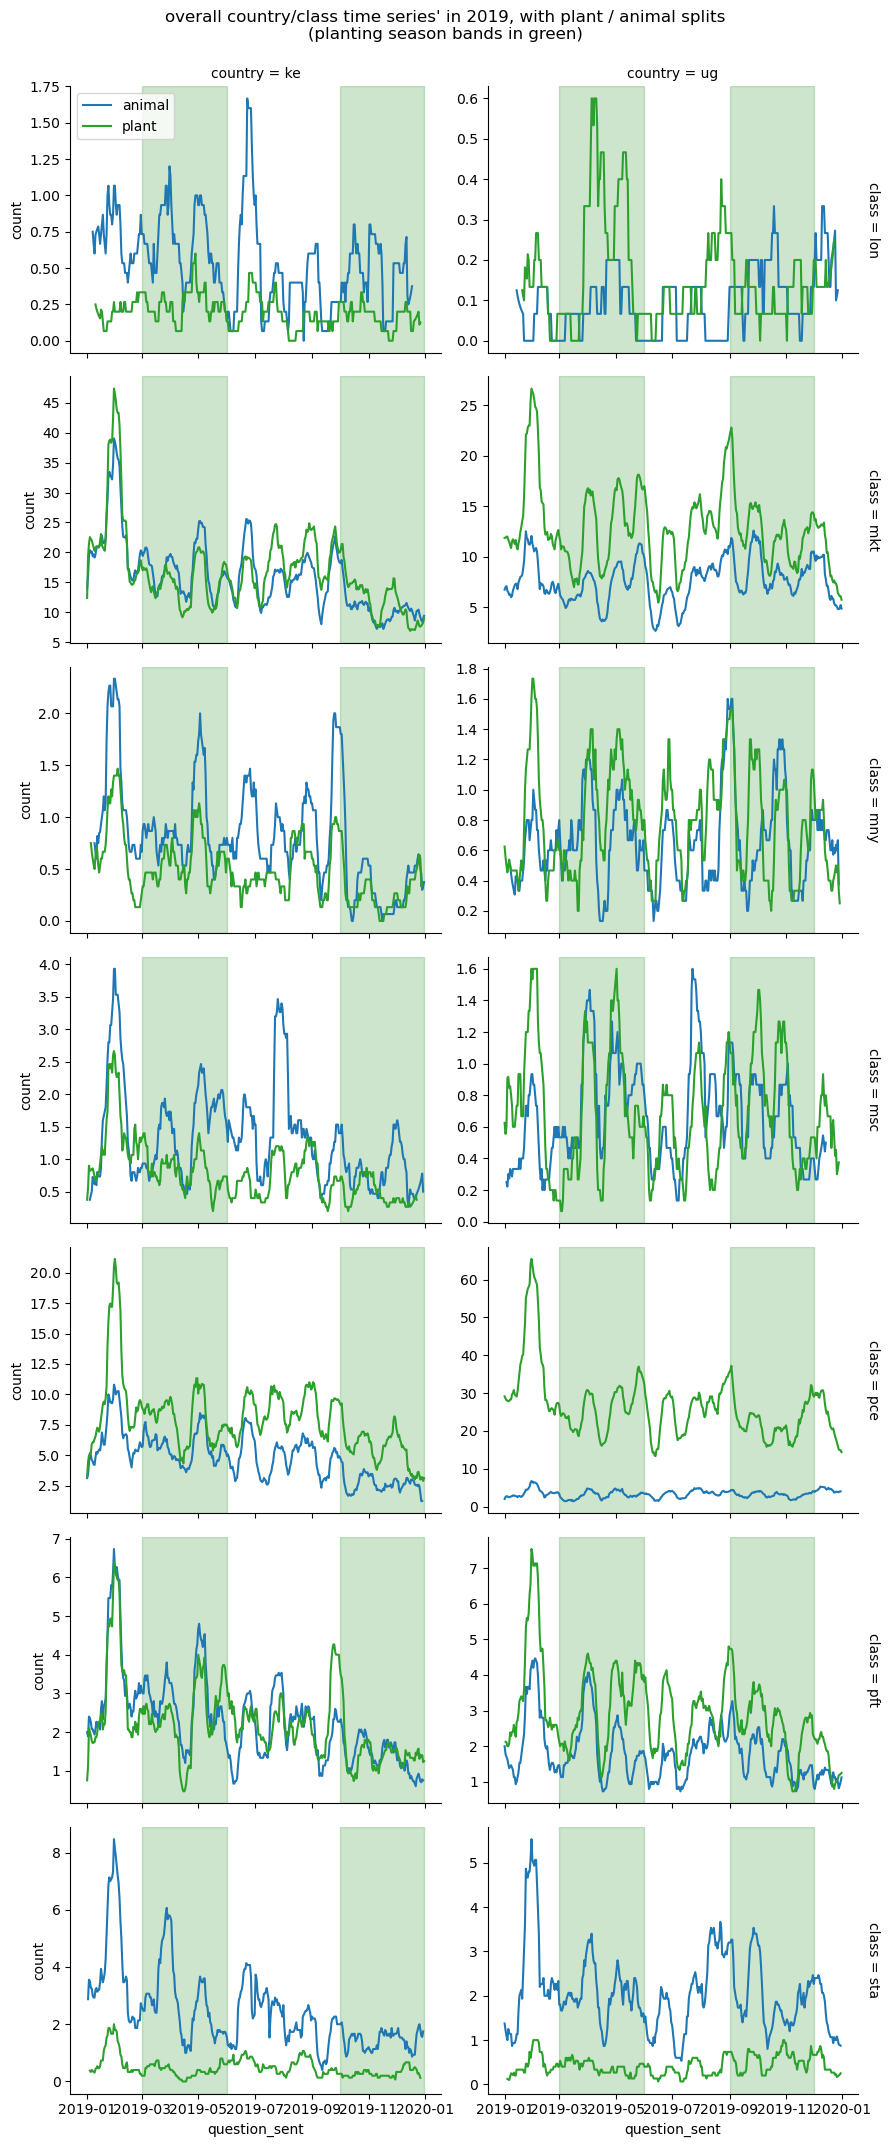

In [125]:
palette = {'plant': 'tab:green', 'animal': 'tab:blue'}

gg = sns.FacetGrid(df_plot_pa, row="class", col="country", hue="pa_group", palette=palette, 
                   sharey=False, margin_titles=True,
                  aspect=1.5)
gg.map(sns.lineplot, 'question_sent', 'count')

# Get row and column names
row_names = gg.row_names
col_names = gg.col_names

# Iterate through axes and associate with facet variables
for i, row_val in enumerate(row_names):
    for j, col_val in enumerate(col_names):
        ax = gg.axes[i, j]
        #ax = None
        #print(f"Plot at row '{row_val}', column '{col_val}' (Axes object: {ax})")
        band_dct = pa_dct[col_val]
        for key in band_dct:
        	ax.axvspan(band_dct[key][0], band_dct[key][1], color='green', alpha=0.2)

handles, labels = gg.axes[0, 0].get_legend_handles_labels()
gg.axes[0, 0].legend(handles=handles, labels=labels, loc="upper left")
gg.fig.suptitle("overall country/class time series' in %s, with plant / animal splits\n(planting season bands in green)" % year_int, y=1.02) # Adjust 'y' for vertical positioning


plt.show()


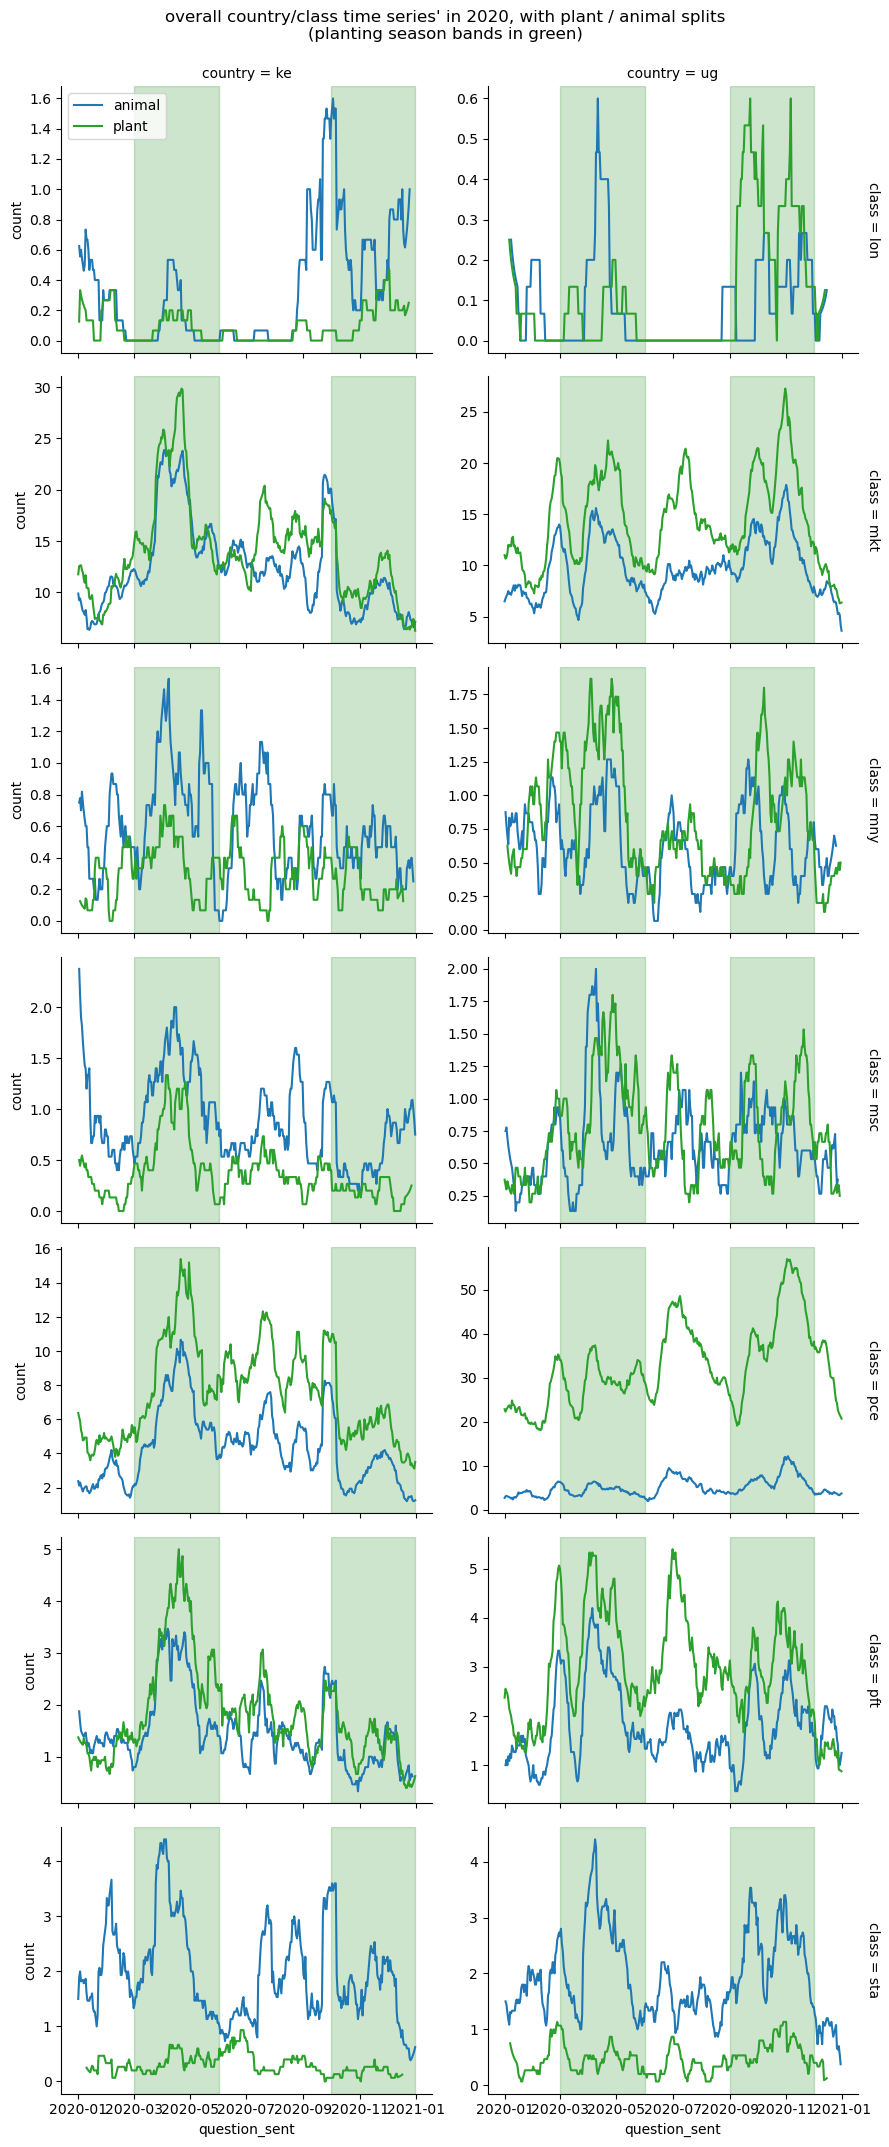

In [81]:
# same code run, for 2020:

In general,

* for the plotted years, 2019 and 2020, Uganda tends to be more crop-prevalent, and Kenya somewhat more animal-prevalent in financial inclusion questions for all classes but the startup class
    * notably, for the price class, Uganda shows a large proportion of price-related questions pertaining to crops, vs. animals
    * for startup-related questions, livestock animals dominate the topics for both countries
* for planting/harvesting seasonal trends, again, as with the general financial inclusion topic plots, it is difficult to identify much seasonality among the large monthly or quarterly oscillations

## Crop and animal specific question topics totals, by year and class

This set of plots considers the original topic labeling in the raw dataset, raw_dataset_producers_direct.csv. For each country, year combination, the top 10 most frequent topics among financial inclusion questions are recorded. These frequencies are used to create an expected frequency for each of the top 10 topics, over all financial inclusion classes for that country, year combination. Next, the frequencies of the top 10 topics are calculated per class ('lon', 'mkt', etc.) for each country, year combination. Bar plots are produced, one set for each country. Each set contains the 4 years, 2018-2021, and the 7 financial inclusion classes. The topic counts among each financial inclusion class's questions for that country / year's top 10 topics are recorded as bar heights. The expected frequencies for the top 10 topics appear as black reference lines for each bar.

For example, for the year 2018, Kenya, the most frequent topics, by count, among the financial inclusion question topics are, chicken:7669, maize:3779, ... These top 10 are normalized to proportions, whose sum is 1. The actual topic frequency counts are repeated, within 2018, Kenya, for each of the 7 financial inclusion classes. For example, in 2018, Kenya, for the loan category, the topic poultry appears 26 times among questions categorized as 'lon.' An expected value for each topic count for, 2018, Kenya, in each class, is computed by summing all counts in that class in the top 10 for 2018, Kenya (for example 'lon' sees 120 total instances among the top 10 topics for Kenya that year) and multiplying by the 2018, Kenya expected proportions. Bars that are very far above or below the expectation reference lines may indicate unusual activity related to that topic and that financial inclusion class.

Notes:
* the financial inclusion classes have high skew toward market and price related questions, so the top 10 topics proportions will skew heavily to the topic frequencies in those two classes
* the topic 'plant' appears frequently. This as a topic label is somewhat ambiguous--both as a broad category, not crop specific, and also may have triggered off phrases like "How many tomatoes should I plant?"

In [42]:
df_fi_bar = df_fi_dt.reset_index()
df_fi_bar['year'] = df_fi_bar['question_sent'].dt.year
def clean_topics(text):
    lst = re.sub(r"[{}']","",text).split(',')
    return [el.strip() for el in lst]
df_fi_bar['clean_topics'] = df_fi_bar['org_topics'].apply(clean_topics)

In [43]:
df_fi_bar = df_fi_bar.loc[df_fi_bar['year']!=2017]   # 2017 has only a few weeks' of data

In [12]:
# slow--ca 45 seconds
df_bar_tot = df_fi_bar.groupby(['question_user_country_code','year'])['clean_topics'].sum()  # topics lists are summed

In [13]:
df_bar_tot_frq = df_bar_tot.apply(lambda x: None if x==0 else Counter(x).most_common())   # pandas series

In [14]:
df_bar_tot_frq.index

MultiIndex([('ke', 2018),
            ('ke', 2019),
            ('ke', 2020),
            ('ke', 2021),
            ('ug', 2018),
            ('ug', 2019),
            ('ug', 2020),
            ('ug', 2021)],
           names=['question_user_country_code', 'year'])

In [15]:
df_bar_tot_frq[:2]

question_user_country_code  year
ke                          2018    [(nan, 10383), (chicken, 7669), (maize, 3779),...
                            2019    [(nan, 8708), (chicken, 4228), (cattle, 2301),...
Name: clean_topics, dtype: object

In [16]:
df_bar_sub = df_fi_bar.groupby(['question_user_country_code','year','class'])['clean_topics'].sum()  # topics lists are summed

In [17]:
df_bar_sub_frq = df_bar_sub.apply(lambda x: None if x==0 else Counter(x).most_common())

In [18]:
len(df_bar_sub_frq)

56

In [19]:
# determine per-year, per-country "top 10" products (excluding 'nan')
def top_10(lst):
    return [(product,num) for product,num in lst if product != 'nan'][:10]
ser_top_10 = df_bar_tot_frq.apply(top_10)

In [20]:
ser_top_10[:3]

question_user_country_code  year
ke                          2018    [(chicken, 7669), (maize, 3779), (cattle, 3421...
                            2019    [(chicken, 4228), (cattle, 2301), (maize, 1670...
                            2020    [(chicken, 3898), (cattle, 1430), (maize, 1219...
Name: clean_topics, dtype: object

In [21]:
ser_top_10_lsts = ser_top_10.apply(lambda x: [el[0] for el in x])

In [22]:
def make_frq_pdf(lst):
    tot = sum([freq for prod,freq in lst])
    return [(prod,freq/tot) for prod,freq in lst]

ser_top_pdf = ser_top_10.apply(make_frq_pdf)

In [23]:
ser_top_pdf[:3]

question_user_country_code  year
ke                          2018    [(chicken, 0.26051362184931043), (maize, 0.128...
                            2019    [(chicken, 0.27284460505937014), (cattle, 0.14...
                            2020    [(chicken, 0.31156582207657263), (cattle, 0.11...
Name: clean_topics, dtype: object

In [24]:
df_bar_sub_frq = pd.merge(df_bar_sub_frq, ser_top_10_lsts, left_index=True, right_index=True, how='left')

In [25]:
df_bar_sub_frq[:3]

clean_topics_x  \
question_user_country_code year class                                                      
ke                         2018 lon    [(nan, 644), (poultry, 26), (pig, 24), (chicke...   
                                mkt    [(nan, 4470), (chicken, 4385), (rabbit, 2559),...   
                                mny    [(nan, 868), (chicken, 181), (cattle, 121), (m...   

                                                                          clean_topics_y  
question_user_country_code year class                                                     
ke                         2018 lon    [chicken, maize, cattle, rabbit, pig, tomato, ...  
                                mkt    [chicken, maize, cattle, rabbit, pig, tomato, ...  
                                mny    [chicken, maize, cattle, rabbit, pig, tomato, ...

In [26]:
# limit products to top 10s
def filter_row(row):
    out_lst = []
    flt_lst = row['clean_topics_y']  # filter on this product list, in order
    prd_lst = row['clean_topics_x']  # tuples (product,frq)
    prd_lst_cln = [product for product,freq in prd_lst]
    for el in flt_lst: # in order
        try:
            ix = prd_lst_cln.index(el)
            out_lst.append(prd_lst[ix])
        except ValueError:
            out_lst.append((el,0))
    return out_lst

# Pandas ~insists on converting df_bar_sub_frq series elements as
# series, not lists when putting into dataframe; cast to tuples first:
df_bar_sub_frq = df_bar_sub_frq.apply(filter_row,axis=1)
df_bar_sub_frq.name='prod_frqs'
df_bar_sub_frq = df_bar_sub_frq.apply(tuple)
df_bar_sub_frq = df_bar_sub_frq.to_frame()

In [27]:
df_bar_sub_frq['ct_tt'] = df_bar_sub_frq['prod_frqs'].apply(lambda x: sum([frq for prd,frq in x]))

In [28]:
df_bar_sub_frq.head(3)

prod_frqs  \
question_user_country_code year class                                                      
ke                         2018 lon    ((chicken, 20), (maize, 12), (cattle, 18), (ra...   
                                mkt    ((chicken, 4385), (maize, 2018), (cattle, 1830...   
                                mny    ((chicken, 181), (maize, 112), (cattle, 121), ...   

                                       ct_tt  
question_user_country_code year class         
ke                         2018 lon      120  
                                mkt    17164  
                                mny      746

In [29]:
df_bar_all = pd.merge(df_bar_sub_frq.reset_index(), ser_top_pdf.reset_index(), 
                      on=['question_user_country_code','year'], how='left')

In [30]:
df_bar_all.head(2)

question_user_country_code  year class  \
0                         ke  2018   lon   
1                         ke  2018   mkt   

                                           prod_frqs  ct_tt  \
0  ((chicken, 20), (maize, 12), (cattle, 18), (ra...    120   
1  ((chicken, 4385), (maize, 2018), (cattle, 1830...  17164   

                                        clean_topics  
0  [(chicken, 0.26051362184931043), (maize, 0.128...  
1  [(chicken, 0.26051362184931043), (maize, 0.128...

In [31]:
def exp_prp(row):
    cnv_lst = row['clean_topics']
    ct = row['ct_tt']
    return tuple([(prod,prp*ct) for prod,prp in cnv_lst])

df_bar_all['expected_prp'] = df_bar_all.apply(exp_prp,axis=1)
df_bar_all.drop(columns=['ct_tt','clean_topics'],inplace=True)

In [32]:
df_bar_all.head(3)

question_user_country_code  year class  \
0                         ke  2018   lon   
1                         ke  2018   mkt   
2                         ke  2018   mny   

                                           prod_frqs  \
0  ((chicken, 20), (maize, 12), (cattle, 18), (ra...   
1  ((chicken, 4385), (maize, 2018), (cattle, 1830...   
2  ((chicken, 181), (maize, 112), (cattle, 121), ...   

                                        expected_prp  
0  ((chicken, 31.261634621917253), (maize, 15.404...  
1  ((chicken, 4471.455805421564), (maize, 2203.36...  
2  ((chicken, 194.34316189958557), (maize, 95.765...

In [33]:
df_bar_all.rename(columns={'question_user_country_code':'country','prod_frqs':'frequency','expected_prp':'expected'},inplace=True)

In [ ]:
# for the plotting, because I'd like little reference lines in the bar plots based on 'expected' column,
# I'm going to use ChatGPT

In [34]:
# courtesy ChatGPT; convert into fully long format:
rows = []
for _, row in df_bar_all.iterrows():
    country = row['country']
    year = row['year']
    cls  = row['class']

    freq_tuples = row['frequency']
    exp_tuples  = row['expected']

    for (prod_f, count), (prod_e, expval) in zip(freq_tuples, exp_tuples):
        assert prod_f == prod_e  # safety check; they should match
        rows.append({
            'country':country,
            'year': year,
            'class': cls,
            'product': prod_f,
            'count': count,
            'expected': expval
        })
df_bar_long = pd.DataFrame(rows)

In [35]:
# courtesy ChatGPT: custom bar plotting, to include reference lines
def bar_with_expected(data, color=None, **kwargs):
    # 1. Plot bars
    sns.barplot(
        data=data,
        x="product",
        y="count",
        color=color,
        **kwargs
    )
    ax = plt.gca()
    # 2. Add expected-value lines
    for i, row in data.iterrows():
        prod = row["product"]
        expv = row["expected"]
        # x-position of this bar
        # seaborn uses categorical axis, so we use the tick index
        xpos = list(data["product"].unique()).index(prod)
        # draw a short horizontal line at expected
        ax.hlines(
            y=expv,
            xmin=xpos - 0.2,
            xmax=xpos + 0.2,
            colors="black",
            linewidth=2
        )

In [40]:
df_long = df_bar_long.loc[df_bar_long['country']=='ke'].drop(columns='country')

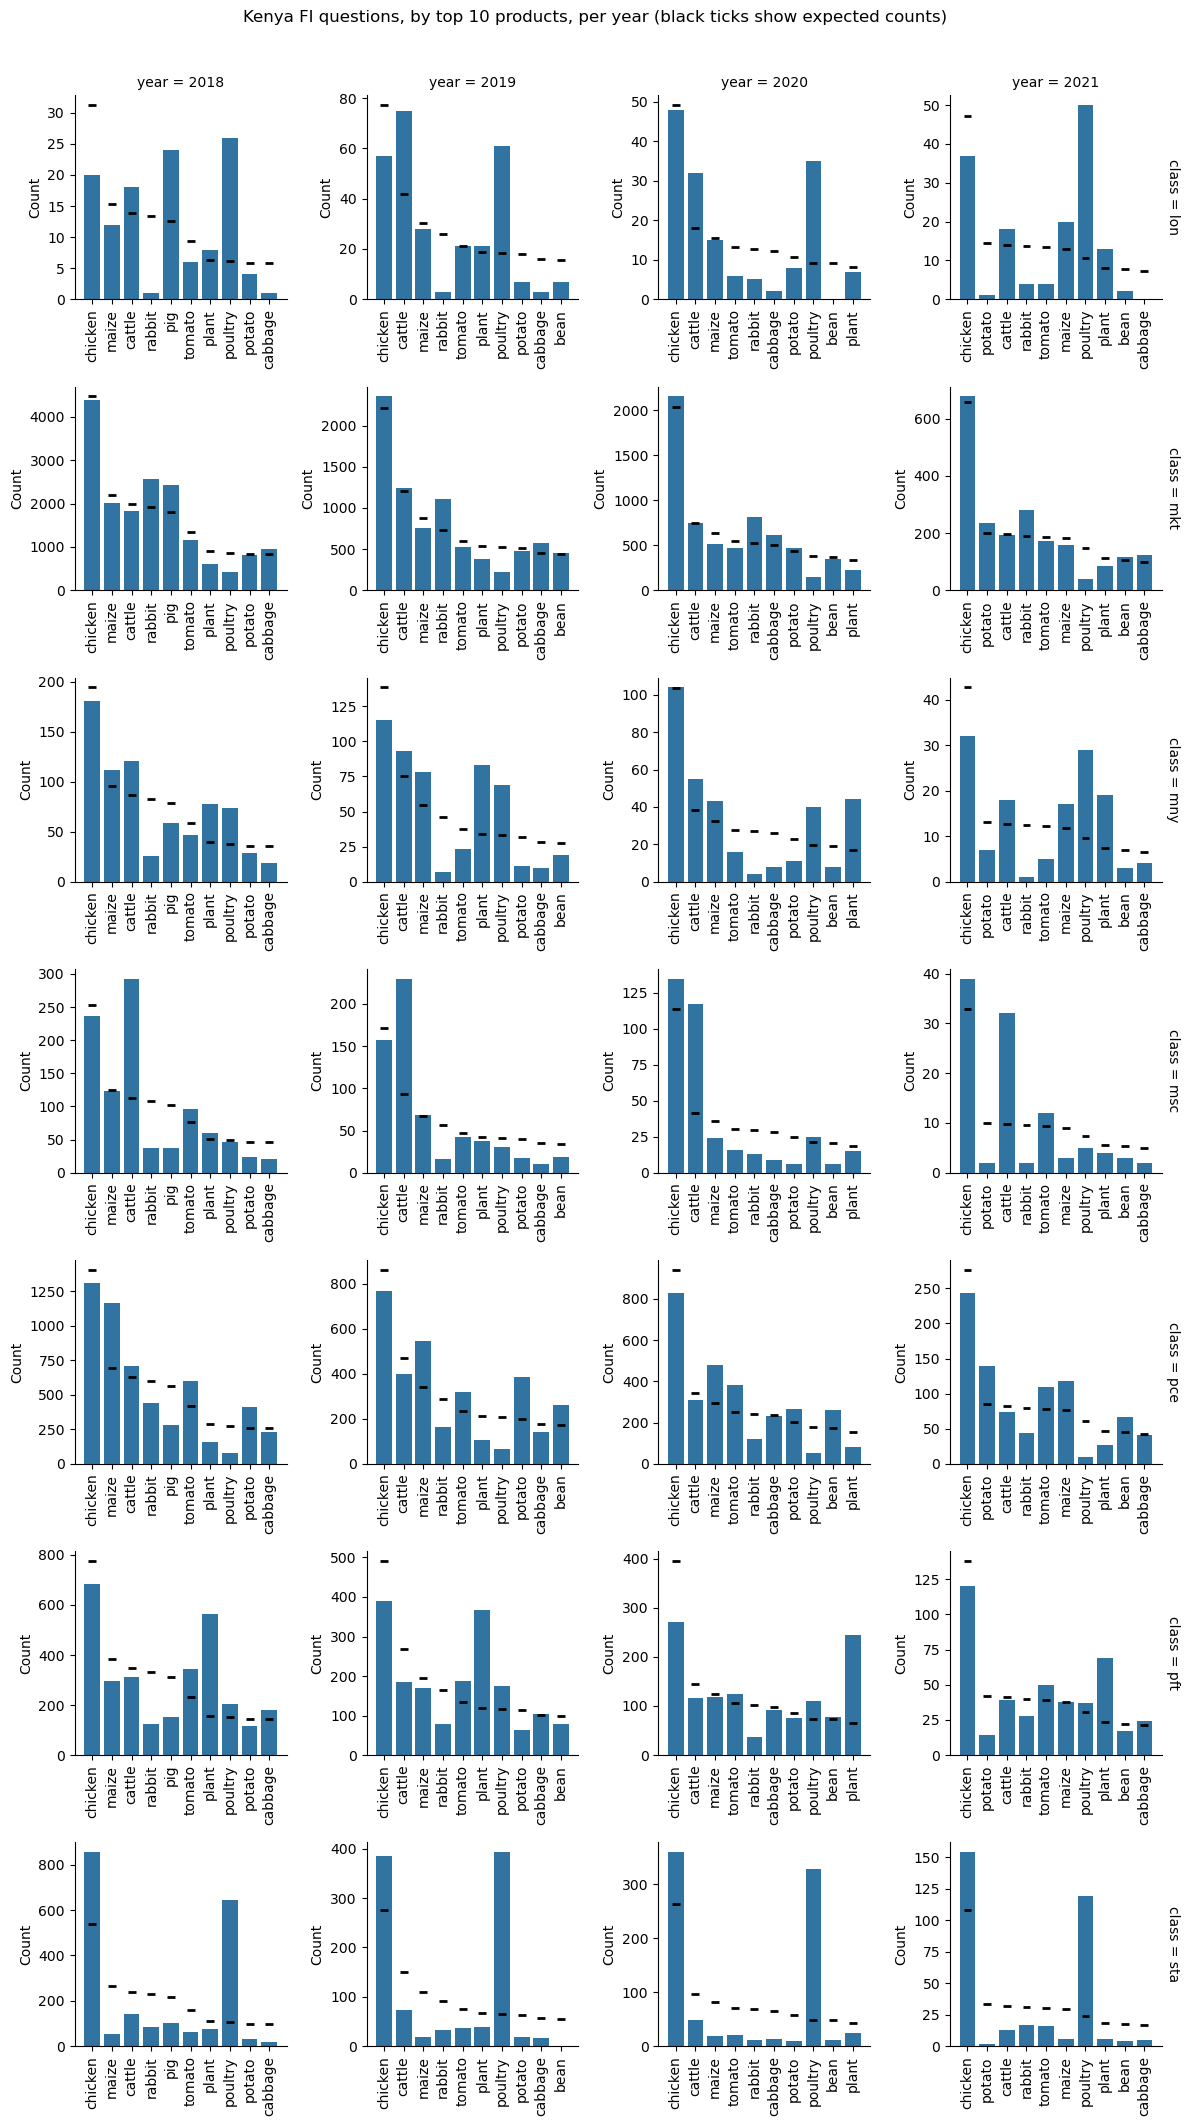

In [41]:
# ChatGPT again: create actual facet plot
gg = sns.FacetGrid(
    df_long,
    row="class",
    col="year",
    margin_titles=True,
    sharey=False,
    sharex=False
)

gg.map_dataframe(bar_with_expected)

# Optional: Better x labels
for ax in gg.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha('center')   # or 'right' if you prefer
    ax.set_xlabel("")
    ax.set_ylabel("Count")

gg.fig.suptitle("Kenya FI questions, by top 10 products, per year (black ticks show expected counts)",y=1.01)
plt.tight_layout()
plt.show()

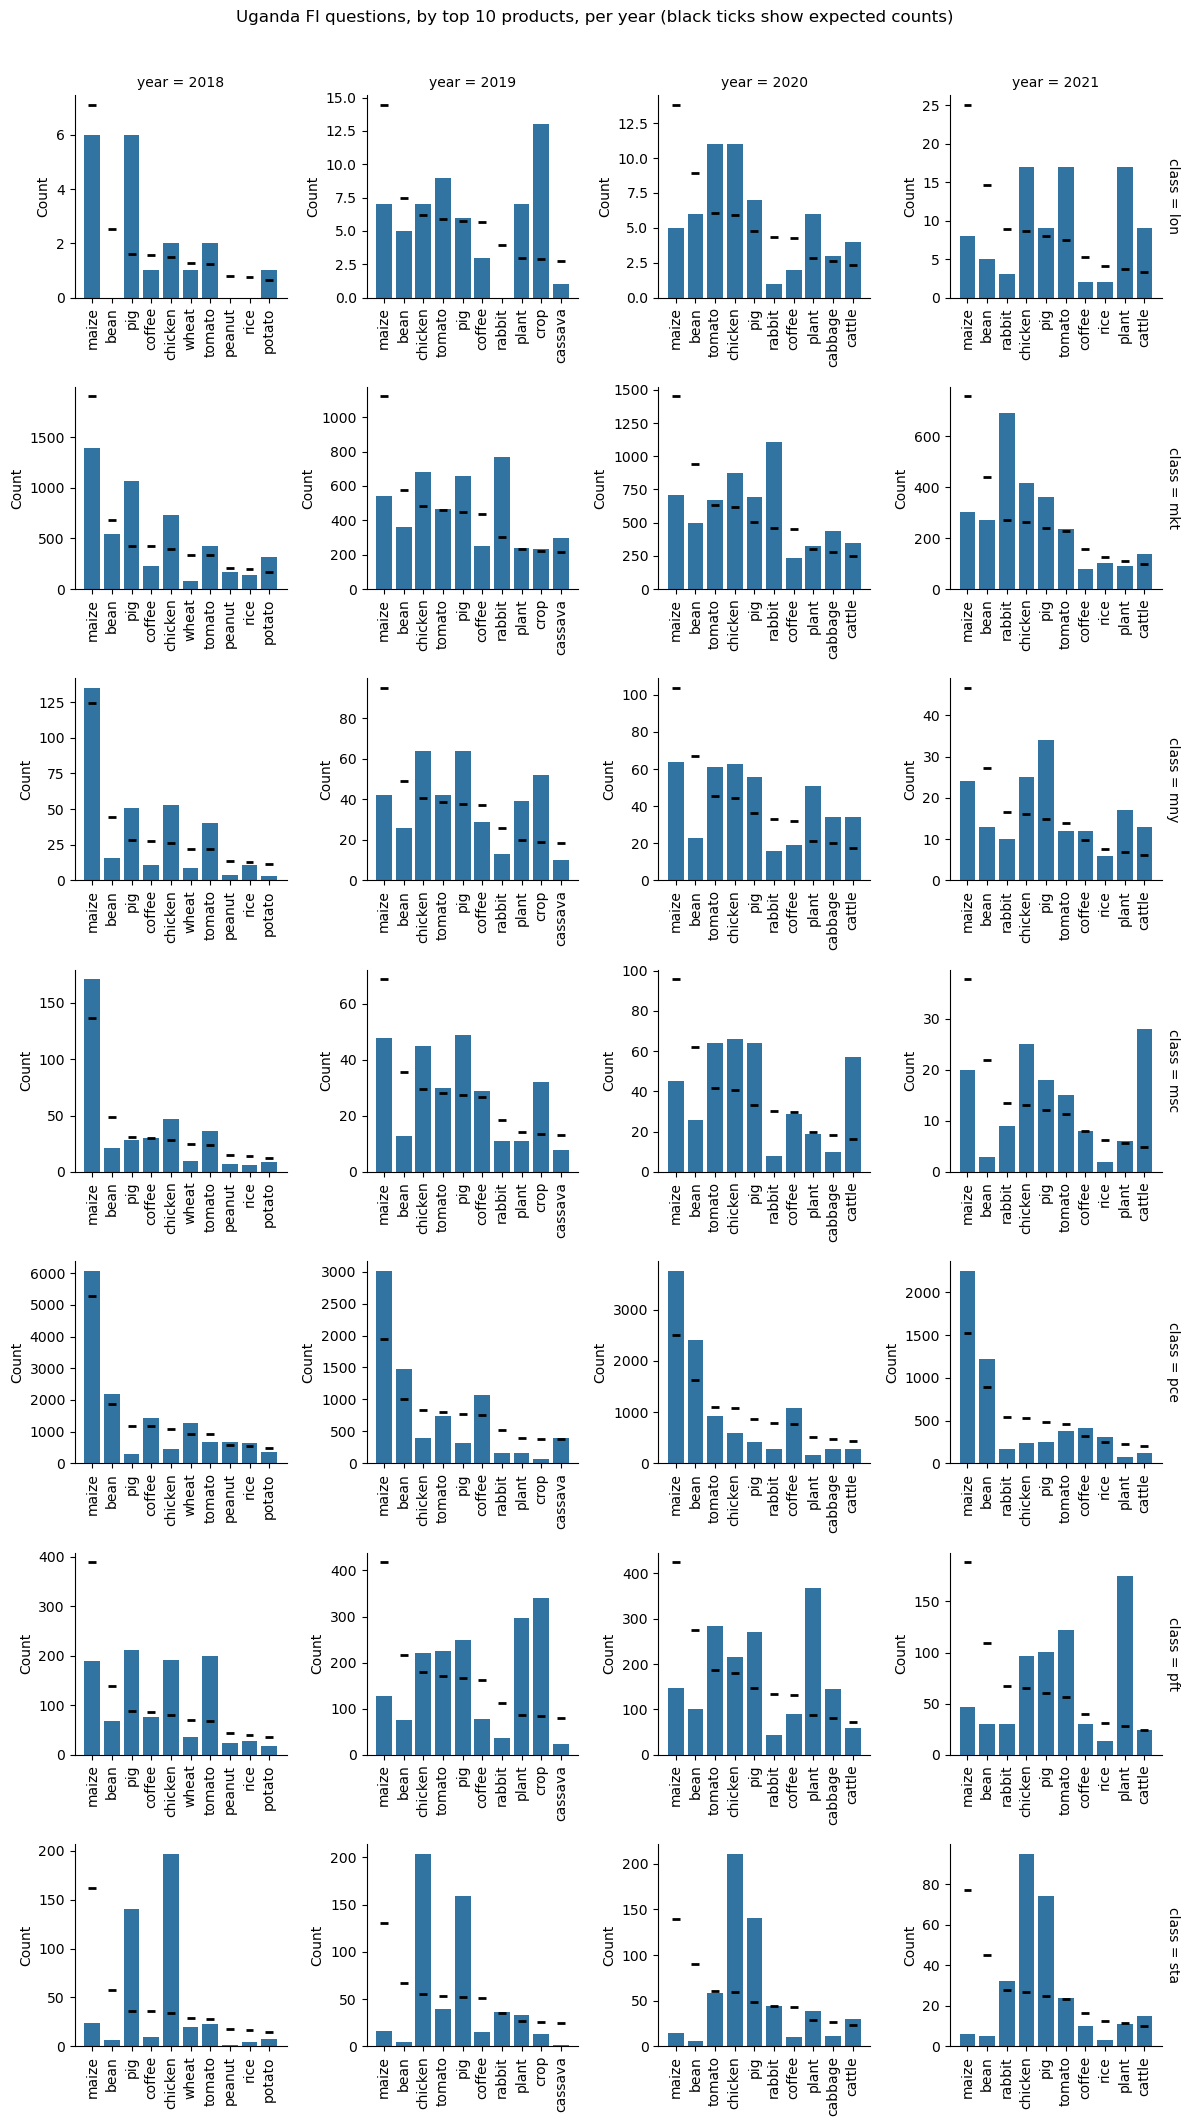

In [39]:
# same code, run on Uganda:

In general,
* loan requests seem more associated with livestock in Kenya, and more associated with crops in Uganda
* questions about startups are disproportionately skewed toward livestock; for example, chicken and poultry for Kenya, and chicken and pigs for Uganda
* pricing questions related to chickens dominate the Kenyan topics, while pricing questions related to maize dominate the Ugandan topics; this reinforces the general prevalence of livestock-related questions for Kenya, and crop-related questions for Uganda
* for the markets class, Uganda has disproportionate market-related questions about rabbits, and somewhat for chicken and pigs

## More time series: crop and animal specific

Next, consider the frequency of questions, by labeled topics, for particular crop- and livestock types. The 4 most frequent crop- and livestock types will be considered. A rolling average of 30 days is used to smooth the plots.


In [126]:
# for the more granular crop- / plant-specific frequencies:

# note, df_fi_1 as-is was filtered in the previous section for the year, year_int

# examine overall most frequent topics
tot_lst = df_fi_1['clean_topics'].sum()   # slow
tot_frq = Counter(tot_lst)
sorted_by_freq = tot_frq.most_common()   # (word,count); this has 67869 total frequency counts for 2019

In [127]:
sorted_by_freq[:10]

[('nan', 14641),
 ('chicken', 5854),
 ('maize', 5465),
 ('cattle', 2914),
 ('bean', 2802),
 ('tomato', 2707),
 ('rabbit', 2437),
 ('pig', 2091),
 ('plant', 1824),
 ('poultry', 1637)]

In [128]:
sum([tup[1] for tup in sorted_by_freq])

67869

In [129]:
rol_avg_pt = 30    # number of days for rolling average

In [130]:
# select the top 4 topics from each plant / animal group:
pl_ts = ['maize','bean','tomato','potato']
an_ts = ['chicken','cattle','rabbit','pig']

Note, in general for these more granular selections, by the time the data is pared to country, class, and single plant / animal topics, the aggregated daily data gets fairly sparse--so in most cases, it's difficult to draw conclusions for the plant / animal-specific time series. This might be more meaningful if constrained to country, class, plant/animal groupings that have more than some threshold of occurrences (over, say, a year)--for example at least 500 of each (or both). Accordingly, the product types will be restricted to the most common, these being maize, chicken, and cattle for 2019, and maize, chicken, and beans for 2020.

In [131]:
# a series with class/country/datetime(day) as index, and clean_topics lists as elements; note the
# element will be 0 if there is no data for that day
df_fi_tp = df_fi_1.groupby(['class','question_user_country_code'])['clean_topics'].resample('D').sum()

In [132]:
df_fi_tp.head(3)

class  question_user_country_code  question_sent            
lon    ke                          2019-01-02 00:00:00+00:00    [nan, nan]
                                   2019-01-03 00:00:00+00:00             0
                                   2019-01-04 00:00:00+00:00             0
Name: clean_topics, dtype: object

In [133]:
df_dc = df_fi_tp.apply(lambda x: None if x==0 else Counter(x))   # pandas series, datetime index, 
# frequency dictionary elements

In [134]:
# for processing each day-row's frequency dictionary, to restrict to 
# main topics
def main_topics_parse(dct):
    if dct is None or dct==0:
        return {tp:0 for tp in pl_ts+an_ts}
    out_dct = {}
    for tp in pl_ts+an_ts:
        if tp not in dct:
            out_dct[tp] = 0
        else:
            out_dct[tp] = dct[tp]
    return out_dct

In [135]:
df_dc = df_dc.apply(main_topics_parse)
df_dc = pd.DataFrame.from_records(df_dc.values,index=df_dc.index)

In [136]:
df_dc.head(3)

maize  bean  \
class question_user_country_code question_sent                            
lon   ke                         2019-01-02 00:00:00+00:00      0     0   
                                 2019-01-03 00:00:00+00:00      0     0   
                                 2019-01-04 00:00:00+00:00      0     0   

                                                            tomato  potato  \
class question_user_country_code question_sent                               
lon   ke                         2019-01-02 00:00:00+00:00       0       0   
                                 2019-01-03 00:00:00+00:00       0       0   
                                 2019-01-04 00:00:00+00:00       0       0   

                                                            chicken  cattle  \
class question_user_country_code question_sent                                
lon   ke                         2019-01-02 00:00:00+00:00        0       0   
                                 2019-01-03 00:00:00+00:00        0       0   
                                 2019-01-04 00:00:00+00:00        0       0   

                                                            rabbit  pig  
class question_user_country_code question_sent                           
lon   ke                         2019-01-02 00:00:00+00:00       0    0  
                                 2019-01-03 00:00:00+00:00       0    0  
                                 2019-01-04 00:00:00+00:00       0    0

In [137]:
df_dc.loc[('mkt','ke',slice(None))].head(5)

maize  bean  tomato  potato  chicken  cattle  \
question_sent                                                             
2019-01-01 00:00:00+00:00      1     0       2       0        9       6   
2019-01-02 00:00:00+00:00      1     0       0       0        4       9   
2019-01-03 00:00:00+00:00      0     0       0       0        2       5   
2019-01-04 00:00:00+00:00      1     0       1       1        5       4   
2019-01-05 00:00:00+00:00      0     0       0       0        4       1   

                           rabbit  pig  
question_sent                           
2019-01-01 00:00:00+00:00       3    0  
2019-01-02 00:00:00+00:00       1    0  
2019-01-03 00:00:00+00:00       1    0  
2019-01-04 00:00:00+00:00       1    1  
2019-01-05 00:00:00+00:00       4    0

In [138]:
df_pt_1 = df_dc[['maize','chicken','cattle']].reset_index()

In [139]:
df_pt_1.head(3)

class question_user_country_code             question_sent  maize  chicken  \
0   lon                         ke 2019-01-02 00:00:00+00:00      0        0   
1   lon                         ke 2019-01-03 00:00:00+00:00      0        0   
2   lon                         ke 2019-01-04 00:00:00+00:00      0        0   

   cattle  
0       0  
1       0  
2       0

In [140]:
df_pt_1 = pd.melt(df_pt_1,id_vars=['class','question_user_country_code','question_sent'],value_vars=['maize','chicken','cattle'])

In [141]:
df_pt_1.head(3)

class question_user_country_code             question_sent variable  value
0   lon                         ke 2019-01-02 00:00:00+00:00    maize      0
1   lon                         ke 2019-01-03 00:00:00+00:00    maize      0
2   lon                         ke 2019-01-04 00:00:00+00:00    maize      0

In [142]:
df_pt_1.set_index('question_sent',inplace=True)
df_pt_1.rename(columns={'variable':'product_type','value':'count'},inplace=True)

In [143]:
# for rolling average:
df_pt_1 = (df_pt_1.sort_index().groupby(['question_user_country_code','class','product_type'])['count']
           .rolling(str(rol_avg_pt)+'D',min_periods=1,center=True)
           .mean()
          )  # needs a datetime index...

In [144]:
df_pt_1.head(3)

question_user_country_code  class  product_type  question_sent            
ke                          lon    cattle        2019-01-02 00:00:00+00:00    0.062500
                                                 2019-01-03 00:00:00+00:00    0.058824
                                                 2019-01-04 00:00:00+00:00    0.166667
Name: count, dtype: float64

In [145]:
df_plot_pt = df_pt_1.reset_index().rename(columns={'question_user_country_code':'country'})

In [146]:
df_plot_pt.head(3)

country class product_type             question_sent     count
0      ke   lon       cattle 2019-01-02 00:00:00+00:00  0.062500
1      ke   lon       cattle 2019-01-03 00:00:00+00:00  0.058824
2      ke   lon       cattle 2019-01-04 00:00:00+00:00  0.166667

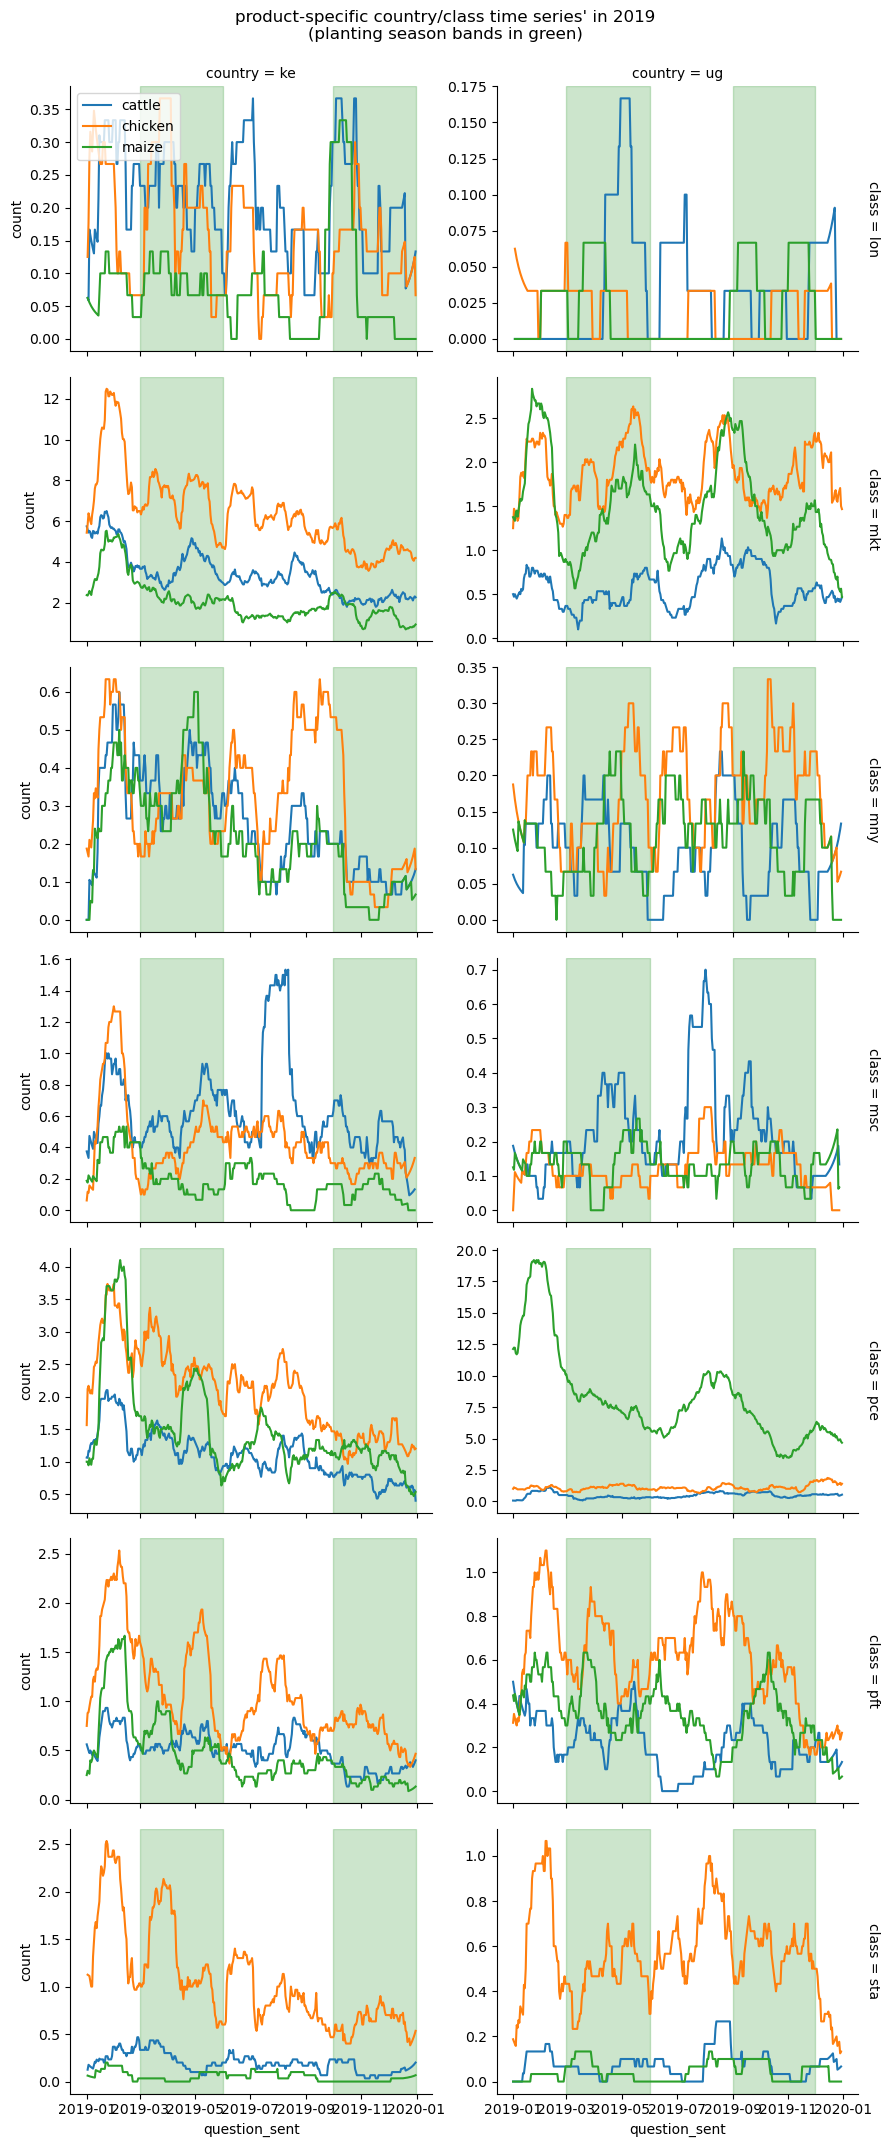

In [147]:
#palette = {'maize': 'tab:yellow', 'chicken': 'tab:blue', 'cattle': 'tab:brown'}

gg = sns.FacetGrid(df_plot_pt, row="class", col="country", hue="product_type",# palette=palette, 
                   sharey=False, margin_titles=True,
                  aspect=1.5)
gg.map(sns.lineplot, 'question_sent', 'count')

# Get row and column names
row_names = gg.row_names
col_names = gg.col_names

# Iterate through axes and associate with facet variables
for i, row_val in enumerate(row_names):
    for j, col_val in enumerate(col_names):
        ax = gg.axes[i, j]
        #ax = None
        #print(f"Plot at row '{row_val}', column '{col_val}' (Axes object: {ax})")
        band_dct = pa_dct[col_val]
        for key in band_dct:
        	ax.axvspan(band_dct[key][0], band_dct[key][1], color='green', alpha=0.2)

handles, labels = gg.axes[0, 0].get_legend_handles_labels()
gg.axes[0, 0].legend(handles=handles, labels=labels, loc="upper left")
gg.fig.suptitle("product-specific country/class time series' in %s\n(planting season bands in green)" % year_int, y=1.02) # Adjust 'y' for vertical positioning


plt.show()


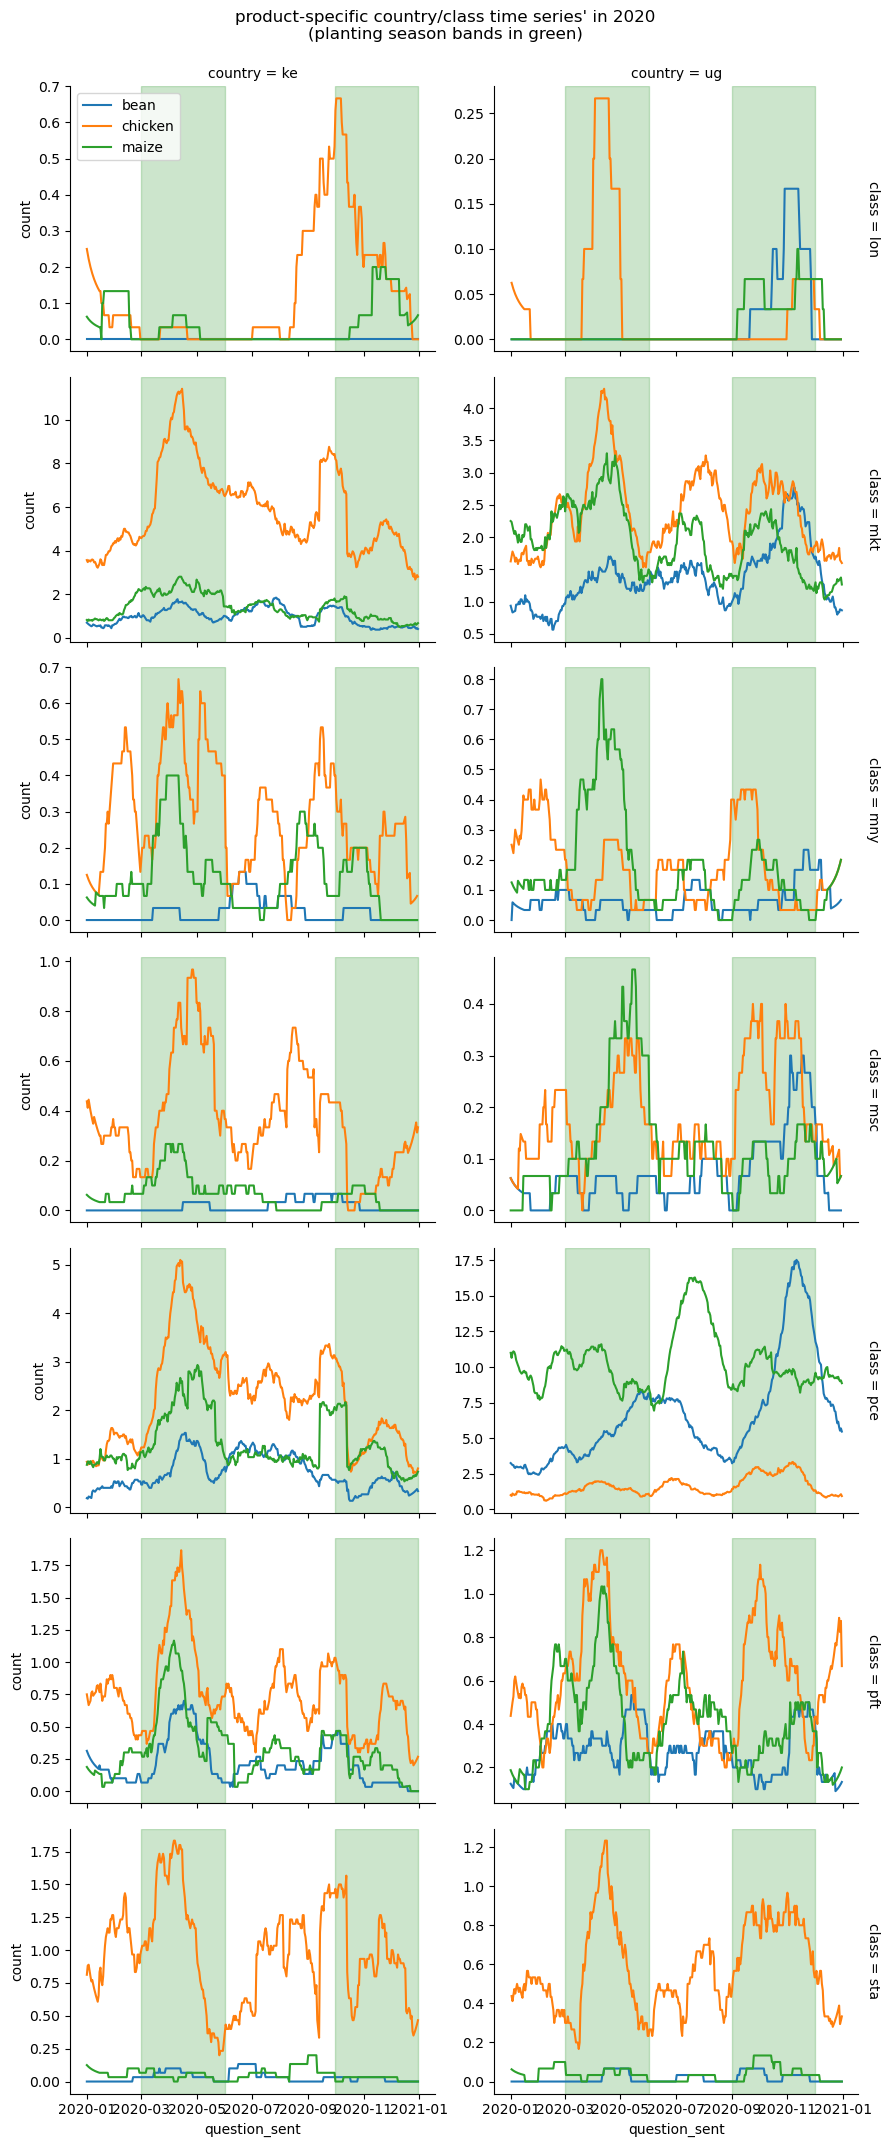

In [104]:
# same code, for 2020:

In general

* there is some weak evidence of seasonality for maize (under price), and chickens (under startups) in Uganda, with oscillations somewhat in sync with planting/harvesting bands
* overall for startup-related questions, reflecting the bar plots, questions related to livestock (chickens) dominate